# Importações de Bibliotecas

In [ ]:
pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import FunctionTransformer
from sklearn import compose
from sklearn import impute
from sklearn import linear_model
from sklearn import model_selection
from sklearn import pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import StratifiedKFold

#Import ANN from KERAS
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import callbacks
from keras.optimizers import Adam


# Conjunto de Dados

In [ ]:
# Acessing dataset 
df = pd.read_excel('/content/drive/MyDrive/TCC/dados_entrada/dados_entrada_ANN.xlsx')

df.set_index('Data',inplace=True)
X = df.drop(['EFL DQO'],axis=1)
y = df['EFL DQO']

#Cria uma cópia do dataset original
df_original = df.copy()

# Funções

## Funções Estatísticas Descritiva

In [ ]:
def create_summary_statistic(df,round_cols=True,number_rounded=3):
  """
  Compute several descriptive statistics of the passed df
  """
  df_stats = df.describe().T
  new_columns = ['Quantidade','Média','Desvio Padrão','Mínimo','25%','50%','75%','Máximo']
  dict_cols = {}
  for i,col in enumerate(df_stats.columns.to_list()):
    dict_cols[col] = new_columns[i]
  df_stats = df_stats.rename(columns=dict_cols)

  from scipy import stats
  dict_stats = dict()
  for row in df:
    dict_stats[row] = stats.describe(df[row])

  df_stats_aux = pd.DataFrame.from_dict(dict_stats,
                                  orient='index',
                                  columns=['Numero de Observações','MinMax','Média','Variância','Skewness','Kurtosis'])
  df_stats_aux.drop(["MinMax",'Numero de Observações','Média',],axis=1,inplace=True)
  df_stats = pd.concat([df_stats,df_stats_aux],axis=1)
  df_stats['CV (%)'] = (df_stats['Desvio Padrão'] / df_stats['Média'])*100
  df_stats = df_stats.round(3)
  return df_stats



def anderson_check_normal_dist(value,critical_value,print_answer=False):
  """
  Reject the null hypothesis (H0) if the value is bigger than critcal_value

  Return True if is normal distribution
  """
  

  if value > critical_value:
    if print_answer:
      print('Null Hypothesis is rejected. It´s not normal distribution')
    return False
  else:
    if print_answer:
      print('Null Hypothesis (H0) is not rejected. It´s normal distribution')
    return True

def shapiro_check_normal_dist(p_value,alpha,print_answer=False):
  """
  The null hypothesis is that this sample is normal distribution
  If p-value is lesser than alpha so reject H0 hypothesis and it´s not normal distribution

  Return True if its normal distribution
  """
  if p_value < alpha:
    if print_answer:
        print('Null Hypothesis is rejected. It´s not normal distribution')
    return False
  else:
    if print_answer:
      print('Null Hypothesis (H0) is not rejected. It´s normal distribution')
    return True

    
def creates_norm_statistcs_df(df,Critical_Value=2,pvalue=0.05):

  """
  Creates a df with 2 tests for normal distribution

  Critical_Value = Int, range [0,4], where represents 15,10,5,2.5 and 1 significance level

  pvalue = Int, range [0,1] that represents the significance level
  """

  from scipy import stats
  #Do a df of Anderson-Darling
  df_aux = df.apply(lambda x:stats.anderson(x)).T
  df_aux = df_aux.rename(columns={0:'Anderson A^2'})
  df_aux['Critical Value'] = [x[Critical_Value] for x in df_aux[1].values]
  _,lista_cv,lista_sl  = stats.anderson(df[df.columns[0]])
  significant_level = lista_sl[Critical_Value]/100
  df_aux['Significance_Level'] = [significant_level for i in range(len(df_aux))]
  df_aux['Anderson-Darling'] = df_aux[["Anderson A^2",
                                       "Critical Value"]].apply(tuple,
                                                                axis=1).apply(lambda x: True if anderson_check_normal_dist(x[0],x[1]) else False)
  #Df from SHAPIRO test
  df_aux_2 = df.apply(lambda x:stats.shapiro(x)).T
  df_aux_2['alpha'] = [pvalue for i in range(len(df_aux_2.index))]
  df_aux_2 = df_aux_2.rename(columns={1:'p_value'})
  df_aux_2['Shapiro'] = df_aux_2[["p_value",
                                       "alpha"]].apply(tuple,
                                                                axis=1).apply(lambda x: True if shapiro_check_normal_dist(x[0],x[1]) else False)
  #Concat both dataframes
  df_aux = pd.concat([df_aux,df_aux_2],axis=1)
  return df_aux




def print_normal_parameters(df_stats):

  """
  Printa os parâmetros que são normalmente distribuidos e retorna uma lista para eles, bem como a lista dos parâmetros que não são.
  """

  #Seleciona os parâmetros que são normalmente distribuidos
  lista_norm = []
  lista_diverg = []
  for data in df_stats.select_dtypes(include='bool').itertuples():
    
    if all(data[1:])==True:
      lista_norm.append(data[0])
    elif data[1:]==tuple((True,False)) :
      lista_diverg.append(data[0])
    elif data[1:]==tuple((False,True)):
      lista_diverg.append(data[0])
    else: pass

  #Printa as colunas

  print('Lista de Parâmetros atestados com distribuição Normal: ')
  print(lista_norm)
  print('Lista de Parâmetros com distribuição para 1 dos testes:')
  if len(lista_diverg)>1:
    print(lista_diverg)
  else:
    print(' Não há parametros')

  return lista_norm, lista_diverg

## Funções Redes Neurais

In [ ]:
def create_df_results(y_test,y_pred):
  #Cria a variavel X
  x = [i for i in range(len(y_pred))]

    #Cria um dataframe para poder visualizar as variáveis
  df_results = pd.DataFrame()

  df_results['X'] = x
  df_results['pred'] = y_pred
  df_results['y_test'] = y_test.values
  df_results['residuals'] = df_results['y_test'] - df_results['pred']
  df_results['abs residuals'] = abs( df_results['y_test'] - df_results['pred'])
  df_results.sort_values(by=['y_test'],axis=0,ignore_index=True,inplace=True)

  return df_results


def print_metrics(y_test,y_pred,retur = False,num_variables=int(),printed=True):
  from sklearn.metrics import explained_variance_score,mean_squared_error,r2_score
  #Adj r2 = 1-(1-R2)*(n-1)/(n-p-1)
  r2_ajust = 1- (1 - (r2_score(y_test,y_pred)**2))*( (len(X_train)-1) / (len(X_train) - num_variables - 1) )

  if printed:
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))
    #Erro Medio
    print('Soma Erro Medio: ',np.sum(np.subtract(y_test,y_pred)))
    print('R2')
    print(r2_score(y_test,y_pred))
    print('R2_score Ajusted')
    print(r2_ajust)

  if retur == True:
    return mean_squared_error(y_test,y_pred),r2_score(y_test,y_pred),r2_ajust


def create_plot_predict(df_results,y_test,y_pred):
  import plotly.graph_objects as go
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=df_results.index, y=y_pred,
                      mode='lines+markers',
                      name='Predito'))
  fig.add_trace(go.Scatter(x=df_results.index, y=y_test,
                      mode='lines+markers',
                      name='Valor Original'))
  return fig


def cria_df_resultados_ANN(df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly):
  colunas_uniao = df_results_ANN_3ly.columns.to_list()
  df_results_ANN_1ly['Numero de Neuronios 2 camada'] = ['-' for i in range(len(df_results_ANN_1ly))]
  df_results_ANN_1ly['Numero de Neuronios 3 camada'] = ['-' for i in range(len(df_results_ANN_1ly))]
  df_results_ANN_2ly['Numero de Neuronios 3 camada'] = ['-' for i in range(len(df_results_ANN_2ly))]

  df_results_ANN_1ly = df_results_ANN_1ly[colunas_uniao]
  df_results_ANN_2ly = df_results_ANN_2ly[colunas_uniao]

  df_original_uniao_resultados = pd.concat([df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly],axis=0)

  return df_original_uniao_resultados.sort_values(by='Mean Squared Error')


## Funções de GridSearch ANN

### 1 layer

In [ ]:
def build_model_1layer(n_hidden=1, n_neurons=30, learning_rate=0.09, input_shape=20, act_func_intermd = 'relu', act_func_output='linear'):
  """
  This function crates a simple squential model for univariate regression
  """
  #Inicialize Sequential Model
  model = keras.models.Sequential()
  #Add input layer
  model.add((keras.layers.InputLayer(input_shape=input_shape)))
  #Try differents neurons for the first hidden layer
  for layer in range(n_hidden):
      model.add(keras.layers.Dense(n_neurons,activation=act_func_intermd))
    #Output layer
  model.add(keras.layers.Dense(1,activation=act_func_output))
  #Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  #Compile Model
  model.compile(loss='mse', optimizer=optimizer)
  return model



def run_ann_1layer(X_train, y_train, lista_neuronios, batch_sized = 8, learning_rate=0.09, input_shape_GD = 20,
                   activation_func_intermd = 'relu', activation_func_output='linear'):

  """
  RODA A ANN para a busca informada nas listas de neuronios 
  RETORNA UMA SÉRIE DE RESULTADOS PARA CADA NUMERO DE NEURONIO PROPOSTO PELA LISTA
  """

  #LISTAS SAIDAS
  lista_hidden = []
  lista_mse = []
  lista_r2 = []
  lista_r2_ajust = []

  #EARLY STOPPING
  early_stopping = callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01, # minimium amount of change to count as an improvement
      patience=100, # how many epochs to wait before stopping
      restore_best_weights=True )

  # RUN LOOP 

  for hhly in lista_neuronios:

    print('Rodando para',hhly,' neuronios na camada')

    # DIVIDE A BASE DE TREINO PARA PODER RODAR UMA VALIDAÇÃO DENTRO DO PRÓPRIO MODELO 
    X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)

    # CONSTROI O MODELO DE REDE NEURAL
    model = build_model_1layer(n_hidden=1, 
                        n_neurons=hhly,
                        input_shape = input_shape_GD,
                        learning_rate = learning_rate,
                        act_func_intermd = activation_func_intermd,
                        act_func_output= activation_func_intermd )

    # Train the ANN
    model.fit(X_train_train, y_train_train,
              batch_size = batch_sized,
              epochs =1000,
              callbacks=[early_stopping],
              validation_data=(X_test_test,y_test_test),
              verbose=0
    )


    #Predict 
    y_pred = model.predict(X_test)

    y_pred = y_pred.reshape(1,-1)[0]

    #df resultados
    df_results = create_df_results(y_test,y_pred)

    #Print results
    mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=False)

    lista_hidden.append(hhly)
    lista_mse.append(mean_sqr_error)
    lista_r2.append(r2_scor)
    lista_r2_ajust.append(r2_ajust)

  return lista_hidden, lista_mse, lista_r2, lista_r2_ajust



def creates_df_ANN_results(lista_hidden, lista_mse, lista_r2, lista_r2_ajust):
  df_scores = pd.DataFrame()
  df_scores['Numero de Neuronios 1 camada'] = lista_hidden
  df_scores['Mean Squared Error'] = lista_mse
  df_scores['R2'] = lista_r2
  df_scores['R2 ajustado'] = lista_r2_ajust
  df_scores.sort_values(by=['Mean Squared Error'])

  return df_scores

### 2 layers

In [ ]:

def build_model_2layer(n_neurons_1=30,
                       n_neurons_2=10,
                       learning_rate=0.09,
                       input_shape=20,
                       act_func_intermd = 'relu',
                       act_func_output='linear'
                       ):
  """
  This function crates a simple squential model for univariate regression
  """
  #Inicialize Sequential Model
  model = keras.models.Sequential()
  #Add input layer
  model.add((keras.layers.InputLayer(input_shape=input_shape)))
  #Try differents neurons for the first hidden layer
  model.add(keras.layers.Dense(n_neurons_1,activation=act_func_intermd))
  #Second layer
  model.add(keras.layers.Dense(n_neurons_2,activation=act_func_intermd))
  #Output layer
  model.add(keras.layers.Dense(1,activation=act_func_output))
  #Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  #Compile Model
  model.compile(loss='mse', optimizer=optimizer)
  return model



def run_ann_2layer(X_train,
                   y_train,
                   lista_neuronios_1camada = list(),
                   lista_neuronios_2camada = list(),
                   batch_sized = 8,
                   learning_rate=0.09,
                   input_shape_GD = 20,
                   activation_func_intermd = 'relu',
                   activation_func_output = 'linear'
                   ):

  """
  RODA A ANN para a busca informada nas listas de neuronios 
  RETORNA UMA SÉRIE DE RESULTADOS PARA CADA NUMERO DE NEURONIO PROPOSTO PELA LISTA
  """

  #LISTAS SAIDAS
  lista_hidden_1 = []
  lista_hidden_2 = []
  lista_mse = []
  lista_r2 = []
  lista_r2_ajust = []

  #EARLY STOPPING
  early_stopping = callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01, # minimium amount of change to count as an improvement
      patience=100, # how many epochs to wait before stopping
      restore_best_weights=True )

  # RUN LOOP 

  for hhly in lista_neuronios_1camada:
    X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)
    print('________________________________________________________')
    print('Rodando para',hhly,' neuronios na 1ª camada ')
    for hhly2 in lista_neuronios_2camada:
      print('          - Rodando para',hhly2,' neuronios na 2ª camada')
    

      # DIVIDE A BASE DE TREINO PARA PODER RODAR UMA VALIDAÇÃO DENTRO DO PRÓPRIO MODELO 
      
      # CONSTROI O MODELO DE REDE NEURAL
      model = build_model_2layer( 
                          n_neurons_1=hhly,
                          n_neurons_2 = hhly2,
                          input_shape = input_shape_GD,
                          learning_rate = learning_rate,
                          act_func_intermd = activation_func_intermd,
                          act_func_output= activation_func_intermd )

      # Train the ANN
      model.fit(X_train_train, y_train_train,
                batch_size = batch_sized,
                epochs =1000,
                callbacks=[early_stopping],
                validation_data=(X_test_test,y_test_test),
                verbose=0
      )


      #Predict 
      y_pred = model.predict(X_test)

      y_pred = y_pred.reshape(1,-1)[0]

      #df resultados
      df_results = create_df_results(y_test,y_pred)

      #Print results
      mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=False)

      lista_hidden_1.append(hhly)
      lista_hidden_2.append(hhly2)
      lista_mse.append(mean_sqr_error)
      lista_r2.append(r2_scor)
      lista_r2_ajust.append(r2_ajust)

  return lista_hidden_1, lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust


def creates_df_ANN_results_2layer(lista_hidden_1,lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust):
  df_scores = pd.DataFrame()
  df_scores['Numero de Neuronios 1 camada'] = lista_hidden_1
  df_scores['Numero de Neuronios 2 camada'] = lista_hidden_2
  df_scores['Mean Squared Error'] = lista_mse
  df_scores['R2'] = lista_r2
  df_scores['R2 ajustado'] = lista_r2_ajust
  df_scores.sort_values(by=['Mean Squared Error'])

  return df_scores 

### 3 layers

In [ ]:
def build_model_3layer(n_neurons_1=32,
                       n_neurons_2=16,
                       n_neurons_3=8,
                       learning_rate=0.09,
                       input_shape=20,
                       act_func_intermd = 'relu',
                       act_func_output='linear'
                       ):
  """
  This function crates a simple squential model for univariate regression
  """
  #Inicialize Sequential Model
  model = keras.models.Sequential()
  #Add input layer
  model.add((keras.layers.InputLayer(input_shape=input_shape)))
  #Try differents neurons for the first hidden layer
  model.add(keras.layers.Dense(n_neurons_1,activation=act_func_intermd))
  #Second layer
  model.add(keras.layers.Dense(n_neurons_2,activation=act_func_intermd))
  #Second layer
  model.add(keras.layers.Dense(n_neurons_3,activation=act_func_intermd))
  #Output layer
  model.add(keras.layers.Dense(1,activation=act_func_output))
  #Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  #Compile Model
  model.compile(loss='mse', metrics=['mean_squared_error'], optimizer=optimizer)
  return model



def run_ann_3layer(
                   X_train,
                   y_train,
                   lista_neuronios_1camada = list(),
                   lista_neuronios_2camada = list(),
                   lista_neuronios_3camada = list(),
                   batch_sized = 8,
                   learning_rate=0.09,
                   input_shape_GD = 20,
                   activation_func_intermd = 'relu',
                   activation_func_output = 'linear'
                   ):

  """
  RODA A ANN para a busca informada nas listas de neuronios 
  RETORNA UMA SÉRIE DE RESULTADOS PARA CADA NUMERO DE NEURONIO PROPOSTO PELA LISTA
  """

  #LISTAS SAIDAS
  lista_hidden_1 = []
  lista_hidden_2 = []
  lista_hidden_3 = []
  lista_mse = []
  lista_r2 = []
  lista_r2_ajust = []

  #EARLY STOPPING
  early_stopping = callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01, # minimium amount of change to count as an improvement
      patience=100, # how many epochs to wait before stopping
      restore_best_weights=True )

  # RUN LOOP 

  for hhly in lista_neuronios_1camada:

    X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)
    print('________________________________________________________')
    print('Rodando para',hhly,' neuronios na 1ª camada ')

    for hhly2 in lista_neuronios_2camada:
      print('          - Rodando para',hhly2,' neuronios na 2ª camada')

      for hhly3 in lista_neuronios_3camada:
        print('                       - Rodando para',hhly2,' neuronios na 3ª camada')

        # CONSTROI O MODELO DE REDE NEURAL
        model = build_model_2layer( 
                            n_neurons_1=hhly,
                            n_neurons_2 = hhly2,
                            input_shape = input_shape_GD,
                            learning_rate = learning_rate,
                            act_func_intermd = activation_func_intermd,
                            act_func_output= activation_func_intermd )

        # Train the ANN
        model.fit(X_train_train,
                  y_train_train,
                  batch_size = batch_sized,
                  epochs =1000,
                  callbacks=[early_stopping],
                  validation_data=(X_test_test,y_test_test),
                  verbose=2
        )


        #Predict 
        y_pred = model.predict(X_test)

        y_pred = y_pred.reshape(1,-1)[0]

        #df resultados
        df_results = create_df_results(y_test,y_pred)

        #Print results
        mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=False)

        lista_hidden_1.append(hhly)
        lista_hidden_2.append(hhly2)
        lista_hidden_3.append(hhly3)
        lista_mse.append(mean_sqr_error)
        lista_r2.append(r2_scor)
        lista_r2_ajust.append(r2_ajust)

  return lista_hidden_1, lista_hidden_2, lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust


def creates_df_ANN_results_3layer(lista_hidden_1,lista_hidden_2,lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust):
  df_scores = pd.DataFrame()
  df_scores['Numero de Neuronios 1 camada'] = lista_hidden_1
  df_scores['Numero de Neuronios 2 camada'] = lista_hidden_2
  df_scores['Numero de Neuronios 3 camada'] = lista_hidden_3
  df_scores['Mean Squared Error'] = lista_mse
  df_scores['R2'] = lista_r2
  df_scores['R2 ajustado'] = lista_r2_ajust
  df_scores.sort_values(by=['Mean Squared Error'])

  return df_scores 

# Transformação Linear

In [ ]:
df_stats= create_summary_statistic(df)
df_stats.drop(['Quantidade'],axis=1,inplace=True)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.colheader_justify', 'center',
                       'display.float_format','{:.3f}'.format):
    display(df_stats)

,Média,Desvio Padrão,Mínimo,25%,50%,75%,Máximo,Variância,Skewness,Kurtosis,CV (%)
TEMP AR MEDIO,20.691,3.803,10.591,17.959,21.278,23.476,27.587,14.461,-0.408,-0.485,18.379
UMIDADE RLV,83.702,6.402,58.993,81.270,83.765,86.931,96.358,40.984,-0.639,1.588,7.648
MOLHAMENTO FOLIAR MEDIO,0.416,0.276,0.001,0.164,0.400,0.609,1.000,0.076,0.265,-0.800,66.373
PRESSAO ATM MED,1015.734,5.147,1002.318,1012.076,1015.238,1019.296,1031.188,26.496,0.157,0.004,0.507
RADIACAO SOLAR MEDIA,158.581,75.812,19.613,106.913,149.219,203.470,366.200,5747.501,0.541,-0.197,47.807
VEL MAX VENTO MEDIA,16.392,5.847,6.072,11.739,15.796,21.100,30.033,34.182,0.392,-0.558,35.668
UMIDADE AR MAX,96.618,3.781,78.995,96.265,96.803,99.285,100.000,14.299,-2.309,6.757,3.914
UMIDADE AR MIN,66.017,10.393,42.450,61.010,65.685,70.620,91.210,108.012,0.154,0.356,15.743
TEMP MAX,24.424,3.991,15.670,21.715,24.510,27.365,35.130,15.927,0.038,-0.411,16.340
TEMP MIN,17.564,4.482,4.620,13.955,19.450,20.880,23.930,20.093,-0.753,-0.371,25.521


### Teste de Normalidade

In [ ]:
#Cria Df
df_norm = creates_norm_statistcs_df(df)
#Drop unnecessary columns
df_norm.drop([0,1,2],axis=1,inplace=True)
#Rename Columns
new_columns = ['A²','Valor Critico','Nivel de Significancia','Normal Distribution?','P-Value','Alpha','Normal Distribution?']
dict_cols = {}
for i,col in enumerate(df_norm.columns.to_list()):
  dict_cols[col] = new_columns[i]
df_norm = df_norm.rename(columns=dict_cols)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.colheader_justify', 'center',
                       'display.float_format','{:.3f}'.format):
    display(df_norm)

,A²,Valor Critico,Nivel de Significancia,Normal Distribution?,P-Value,Alpha,Normal Distribution?
TEMP AR MEDIO,0.790,0.759,0.050,False,0.054,0.050,True
UMIDADE RLV,1.915,0.759,0.050,False,0.001,0.050,False
MOLHAMENTO FOLIAR MEDIO,0.865,0.759,0.050,False,0.004,0.050,False
PRESSAO ATM MED,0.266,0.759,0.050,True,0.910,0.050,True
RADIACAO SOLAR MEDIA,1.004,0.759,0.050,False,0.009,0.050,False
VEL MAX VENTO MEDIA,0.717,0.759,0.050,True,0.017,0.050,False
UMIDADE AR MAX,6.650,0.759,0.050,False,0.000,0.050,False
UMIDADE AR MIN,2.087,0.759,0.050,False,0.002,0.050,False
TEMP MAX,0.264,0.759,0.050,True,0.796,0.050,True
TEMP MIN,2.943,0.759,0.050,False,0.000,0.050,False


In [ ]:
_,_ = print_normal_parameters(df_norm)

Lista de Parâmetros atestados com distribuição Normal: 
['PRESSAO ATM MED', 'TEMP MAX', 'RADIACAO SOLAR MAX', 'VEL VENTO MAXIMA MAXIMA', 'TEMP AR 7d', 'TEMP AR MAX 3d', 'VEL MAX VENTO MEDIA 3d', 'AFL_P-PO43-']
Lista de Parâmetros com distribuição para 1 dos testes:
['TEMP AR MEDIO', 'VEL MAX VENTO MEDIA']


## Transformação Logaritmica

In [ ]:
#Seleciona os parâmetros que não são normalmente distribuidos
lista_norm = []
lista_diverg = []
for data in df_norm.select_dtypes(include='bool').itertuples():
  
  if all(data[1:])==True:
    lista_norm.append(data[0])
  elif data[1:]==(True,False) or data[1:]==(False,True):
    lista_diverg.append(data[0])

#Printa as colunas

print('Lista de Parâmetros atestados com distribuição Normal: ')
[print(i,end=', ') for i in lista_norm]
print()
print()
print('Lista de Parâmetros com distribuição para 1 dos testes:')
[print(i,end=', ') for i in lista_diverg]


#Cria listas em que os parâmetros não são normalmente distribuidos
lista_not_norm = [col for col in df.columns if col not in lista_norm]

#Dataframe para aplicar a transformação logaritmica 
df_not_norm = df.loc[:,lista_not_norm].copy()

Lista de Parâmetros atestados com distribuição Normal: 
PRESSAO ATM MED, TEMP MAX, RADIACAO SOLAR MAX, VEL VENTO MAXIMA MAXIMA, TEMP AR 7d, TEMP AR MAX 3d, VEL MAX VENTO MEDIA 3d, AFL_P-PO43-, 

Lista de Parâmetros com distribuição para 1 dos testes:
TEMP AR MEDIO, VEL MAX VENTO MEDIA, 

In [ ]:
## TRANSFORMAÇÃO LOGARITMICA

#Cria um Novo df com a transformação logaritmica aplicada

transformer = FunctionTransformer(np.log1p, validate=True)
df_lognorm = pd.DataFrame(transformer.transform(df_not_norm),columns=df_not_norm.columns.to_list())
df_lognorm = df_lognorm.add_prefix('log ')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Realiza o teste de normalidade para os parâmetros com as transformações logarítmicas
df_stats_lognorm = creates_norm_statistcs_df(df_lognorm)

#Drop colunas desnecessárias
df_stats_lognorm.drop([0,1,2],axis=1,inplace=True)

#Renomeia as colunas
new_columns = ['A²','Valor Critico','Nivel de Significancia','Normal Distribution?','P-Value','Alpha','Normal Distribution?']
dict_cols = {}
for i,col in enumerate(df_stats_lognorm.columns.to_list()):
  dict_cols[col] = new_columns[i]
df_stats_lognorm = df_stats_lognorm.rename(columns=dict_cols)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.colheader_justify', 'center',
                       'display.float_format','{:.3f}'.format):
    display(df_stats_lognorm)


,A²,Valor Critico,Nivel de Significancia,Normal Distribution?,P-Value,Alpha,Normal Distribution?
log TEMP AR MEDIO,1.653,0.759,0.050,False,0.000,0.050,False
log UMIDADE RLV,2.297,0.759,0.050,False,0.000,0.050,False
log MOLHAMENTO FOLIAR MEDIO,0.920,0.759,0.050,False,0.005,0.050,False
log RADIACAO SOLAR MEDIA,1.279,0.759,0.050,False,0.002,0.050,False
log VEL MAX VENTO MEDIA,0.588,0.759,0.050,True,0.106,0.050,True
log UMIDADE AR MAX,7.369,0.759,0.050,False,0.000,0.050,False
log UMIDADE AR MIN,2.258,0.759,0.050,False,0.001,0.050,False
log TEMP MIN,4.695,0.759,0.050,False,0.000,0.050,False
log PRECP,14.492,0.759,0.050,False,0.000,0.050,False
log RADIACAO SOLAR MIN,35.154,0.759,0.050,False,0.000,0.050,False


In [ ]:
lista_cols_lognorm, _ = print_normal_parameters(df_stats_lognorm)

Lista de Parâmetros atestados com distribuição Normal: 
['log VEL MAX VENTO MEDIA', 'log RAD SOLAR MEDIA 3d', 'log AFL_DQO']
Lista de Parâmetros com distribuição para 1 dos testes:
 Não há parametros


## Transformação BoxCox

In [ ]:
#BOXCOX PARA OS PARAMETROS NÃO NORMAIS.

#DATAFRAME COM O BOXCOX APLICADO
df_boxcox= pd.DataFrame(data = np.array([array.tolist() for array in df_not_norm.apply(lambda col:stats.boxcox(col.apply(lambda x:x+1))).iloc[0].values]).T,
                        columns=df_not_norm.apply(lambda col:stats.boxcox(col.apply(lambda x:x+1))).iloc[0].index)

In [ ]:
#DATAFRAME CONTENDO OS VALORES DE LAMBDAS DE CADA TRANSFORMAÇÃO 
df_lambda_boxcox= pd.DataFrame(data = np.array([array.tolist() for array in df_not_norm.apply(lambda col:stats.boxcox(col.apply(lambda x:x+1))).iloc[1].values]).T,
                               index=df_not_norm.apply(lambda col:stats.boxcox(col.apply(lambda x:x+1))).iloc[1].index,columns=['Lambda'])

# Visualizando o labmda
df_lambda_boxcox

,Lambda
TEMP AR MEDIO,1.878292
UMIDADE RLV,3.071957
MOLHAMENTO FOLIAR MEDIO,0.114783
RADIACAO SOLAR MEDIA,0.498005
VEL MAX VENTO MEDIA,0.322746
UMIDADE AR MAX,18.496757
UMIDADE AR MIN,0.745080
TEMP MIN,2.262707
PRECP,-1.133196
RADIACAO SOLAR MIN,-8.914170


In [ ]:
# VISUALIZANDO O DATASET


df_stats_boxcox = creates_norm_statistcs_df(df_boxcox)
#Drop unnecessary columns
df_stats_boxcox.drop([0,1,2],axis=1,inplace=True)
#Rename Columns
new_columns = ['A²','Valor Critico','Nivel de Significancia','Normal Distribution?','P-Value','Alpha','Normal Distribution?']
dict_cols = {}
for i,col in enumerate(df_stats_boxcox.columns.to_list()):
  dict_cols[col] = new_columns[i]
df_stats_boxcox = df_stats_boxcox.rename(columns=dict_cols)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.colheader_justify', 'center',
                       'display.float_format','{:.3f}'.format):
    display(df_stats_boxcox)

,A²,Valor Critico,Nivel de Significancia,Normal Distribution?,P-Value,Alpha,Normal Distribution?
TEMP AR MEDIO,0.451,0.759,0.050,True,0.274,0.050,True
UMIDADE RLV,1.770,0.759,0.050,False,0.009,0.050,False
MOLHAMENTO FOLIAR MEDIO,0.887,0.759,0.050,False,0.006,0.050,False
RADIACAO SOLAR MEDIA,0.416,0.759,0.050,True,0.440,0.050,True
VEL MAX VENTO MEDIA,0.441,0.759,0.050,True,0.193,0.050,True
UMIDADE AR MAX,2.340,0.759,0.050,False,0.000,0.050,False
UMIDADE AR MIN,2.054,0.759,0.050,False,0.002,0.050,False
TEMP MIN,1.845,0.759,0.050,False,0.001,0.050,False
PRECP,14.550,0.759,0.050,False,0.000,0.050,False
RADIACAO SOLAR MIN,29.517,0.759,0.050,False,0.000,0.050,False


In [ ]:
lista_cols_boxcox, _ = print_normal_parameters(df_stats_boxcox)

Lista de Parâmetros atestados com distribuição Normal: 
['TEMP AR MEDIO', 'RADIACAO SOLAR MEDIA', 'VEL MAX VENTO MEDIA', 'TEMP MEDIANA', 'RAD SOLAR MEDIA 3d', 'EFL DQO', 'AFL_DQO', 'AFLRelação DQO/DBO']
Lista de Parâmetros com distribuição para 1 dos testes:
 Não há parametros


[]

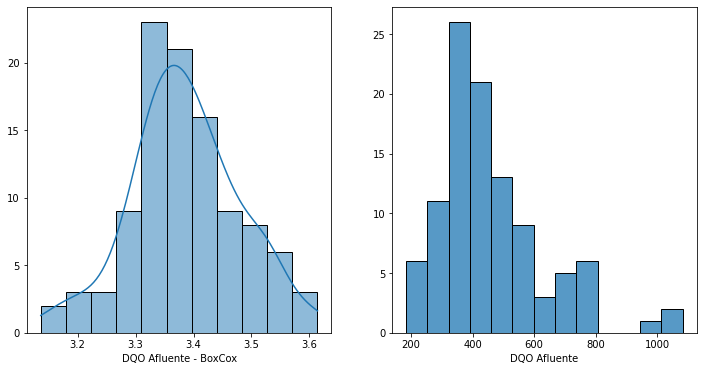

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
sns.histplot(data=df_boxcox['AFL_DQO'],
             ax=axs[0],
             kde=True
             )
sns.histplot(data=df['AFL_DQO'],
             ax=axs[1]
             )
axs[0].set_xlabel('DQO Afluente - BoxCox')
axs[1].set_xlabel('DQO Afluente')
axs[0].set_ylabel('')
axs[1].set_ylabel('')
plt.plot()

### União dos parâmetros normalizados

In [ ]:
# Printa o shape dos df
print(df[lista_norm].shape,df_boxcox.shape,df.shape)

#Unificando os indices
df_boxcox.index = df[lista_norm].index

#Une os dataframes
df_normal = pd.concat([df[lista_norm],df_boxcox],axis=1)

print('O shape do df é:', df_normal.shape)

# Altera o nome do dataset pra simplificação das linhas de código
df = df_normal.copy()

(103, 8) (103, 34) (103, 42)
O shape do df é: (103, 42)


# Seleçao de Melhores Parâmetros - XGBoost

In [ ]:
X = df.drop(['EFL DQO'],axis=1)
#Realiza a normalização do conjunto
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realiza um GridSearch para selecionar os melhores parâmetros que compõem o dataset

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.09, .01], #so called `eta` value
              'max_depth': [2,3,4,5,6,7,8],
              'min_child_weight': [3,4,5,6,7],
              'silent': [1],
              'subsample': [0.75],
              'colsample_bytree': [0.7,0.9],
              'n_estimators': [200,500,1000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_scaled,
         y.values)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 630 candidates, totalling 1890 fits
-1.0316795320055625
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75}


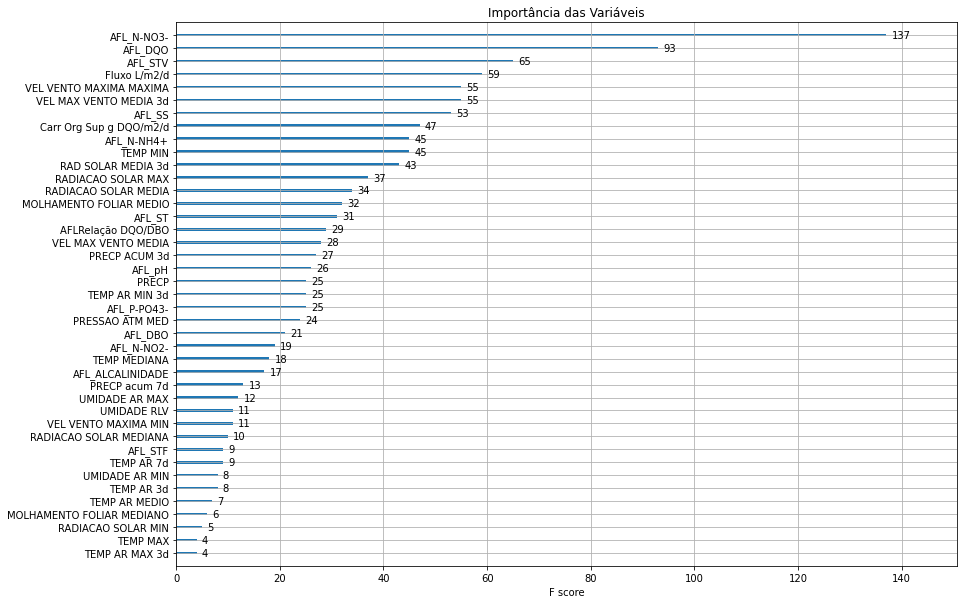

In [ ]:
# Visualizando o melhores parâmetros 
from xgboost import plot_importance


# fit model no training data
model = XGBRegressor(colsample_bytree = 0.7,
                     learning_rate = 0.01,
                     max_depth = 4,
                     min_child_weight = 4,
                     n_estimators = 200,
                     nthread = 4,
                     objective =  'reg:linear',
                     silent = 1,
                     subsample = 0.75
                     )
model.fit(X, y)

# plot feature importance
fig, ax = plt.subplots(figsize=(14,10))
plot_importance(model,ax=ax,
                title='Importância das Variáveis',
                ylabel='')
plt.show()

In [ ]:
xgb_df = pd.DataFrame(X.columns)
xgb_df['Feature Importance'] = model.feature_importances_
xgb_df['Feature Importance'] = xgb_df['Feature Importance'].round(3)
xgb_df = xgb_df.sort_values(by='Feature Importance',ascending=False).reset_index()
xgb_df.drop(['index'],axis=1,inplace=True)
xgb_df

,0,Feature Importance
0,AFL_N-NO3-,0.142
1,AFL_DQO,0.093
2,Carr Org Sup g DQO/m2/d,0.073
3,AFL_DBO,0.062
4,UMIDADE AR MIN,0.056
5,AFL_ALCALINIDADE,0.041
6,RAD SOLAR MEDIA 3d,0.040
7,AFL_SS,0.036
8,Fluxo L/m2/d,0.033
9,AFL_N-NO2-,0.028


In [ ]:
#Selecting the most relevants columns
lista_cols_relevantes_all = xgb_df[0].loc[xgb_df['Feature Importance']>0.015]
print('O tamnho da lista de colunas relevantes é de : ',len(lista_cols_relevantes_all),'parâmetros, para um limite de 0.01')

O tamnho da lista de colunas relevantes é de :  19 parâmetros, para um limite de 0.01


In [ ]:
lista_cols_relevantes_all

0                  AFL_N-NO3-
1                     AFL_DQO
2     Carr Org Sup g DQO/m2/d
3                     AFL_DBO
4              UMIDADE AR MIN
5            AFL_ALCALINIDADE
6          RAD SOLAR MEDIA 3d
7                      AFL_SS
8                Fluxo L/m2/d
9                  AFL_N-NO2-
10         AFLRelação DQO/DBO
11             UMIDADE AR MAX
12               TEMP MEDIANA
13            PRESSAO ATM MED
14                UMIDADE RLV
15                    AFL_STV
16    VEL VENTO MAXIMA MAXIMA
17                     AFL_pH
18                      PRECP
Name: 0, dtype: object

[]

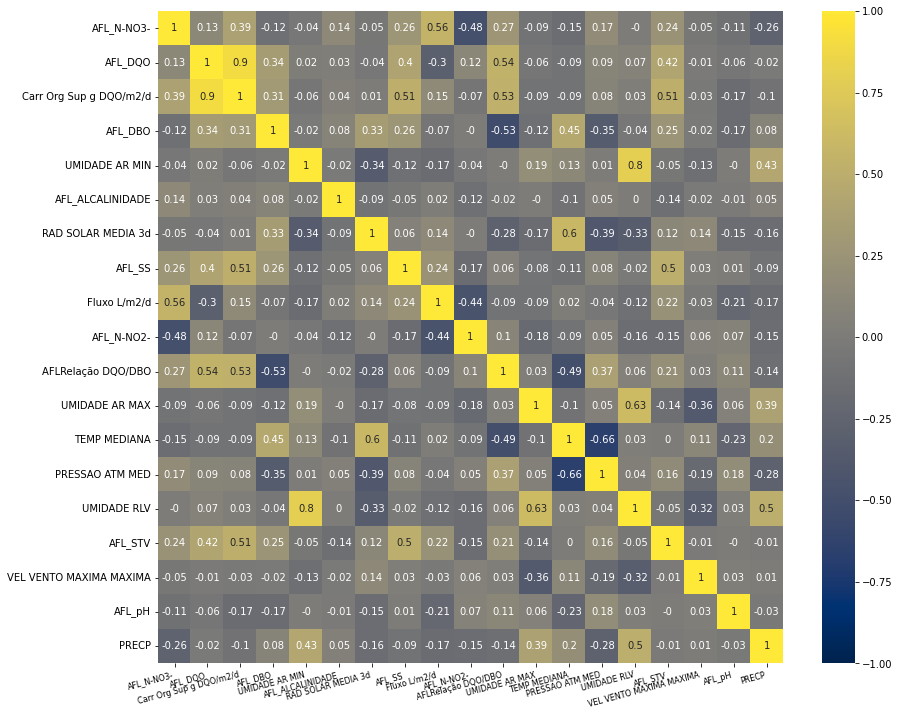

In [ ]:
X_cols_relevantes = df[lista_cols_relevantes_all]
plt.figure(figsize=(14, 12))
g= sns.heatmap(X_cols_relevantes.corr().round(2), annot=True,vmin=-1, vmax=1,center= 0, cmap='cividis')
g.set_xticklabels(g.get_xticklabels(),
                  fontdict = {
                              'horizontalalignment': 'right'},
                  rotation = 15, fontsize = 8)
g.plot()

In [ ]:
#Excluindo parametros redundantes
parametros_redundantes = ['Carr Org Sup g DQO/m2/d','UMIDADE RLV','AFLRelação DQO/DBO']
lista_cols_relevantes = [i for i,v in lista_cols_relevantes_all.items() if v not in parametros_redundantes] 
lista_cols_relevantes = lista_cols_relevantes_all[lista_cols_relevantes]

In [ ]:
print('Lista de Colunas Relevantes: ')
for i in lista_cols_relevantes:
  print(i,end=';')

Lista de Colunas Relevantes: 
AFL_N-NO3-;AFL_DQO;AFL_DBO;UMIDADE AR MIN;AFL_ALCALINIDADE;RAD SOLAR MEDIA 3d;AFL_SS;Fluxo L/m2/d;AFL_N-NO2-;UMIDADE AR MAX;TEMP MEDIANA;PRESSAO ATM MED;AFL_STV;VEL VENTO MAXIMA MAXIMA;AFL_pH;PRECP;

## Parametrização - Plots

AttributeError: ignored

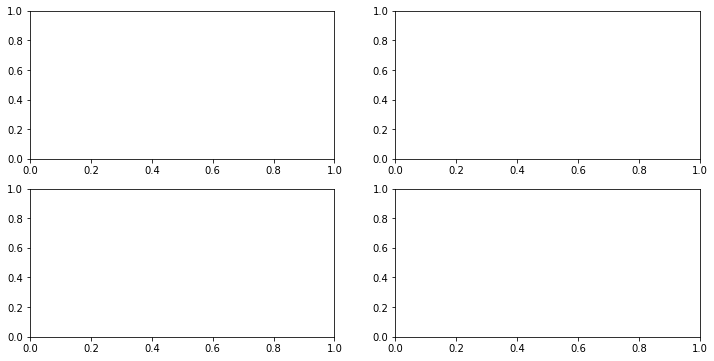

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(data=df_scaled['AFL_DQO'],
             ax=axs[1],
            color = 'darkgray',
            width=0.6,
            linewidth=0.8
             )
sns.boxplot(data=X['AFL_DQO'],
             ax=axs[0],
            color='chocolate',
            width=0.6,
            linewidth=0.8
             )
axs[1].set_xlabel('DQO Afluente - Parametrizado')
axs[0].set_xlabel('DQO Afluente')
axs[1].set_ylabel('')
axs[0].set_ylabel('mg/L')
plt.plot()
print('Média Padronizada DQO Afluente (mg/L) = ', df_scaled['AFL_DQO'].mean().round(3) )
print('Desvio Padrão Padronizado DQO Afluente = ',df_scaled['AFL_DQO'].std().round(2))

# Componentes Principais

In [ ]:

# Parametrização 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Perform PCA 
pca = PCA()
pca.fit(X_scaled)
_scores = pca.transform(X_scaled) # pca.transform gives the scores
# Convert scores to a data frame
df_scores = pd.DataFrame(_scores)

#Cria uma lista para assinalar o nome correto das colunas
lista_pcas = ['PC'+str(i+1) for i in range(len(df_scores.columns))]

#Renomeia as colunas
df_scores = df_scores.set_axis(lista_pcas, axis=1)


# Add labels to score data frame for plotting
df_scores.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41
0,5.488555,-0.446576,1.299199,0.200398,-0.015471,1.258429,0.522412,2.375236,2.143512,1.955779,...,-0.083741,-0.223752,0.121594,0.037331,-0.064964,-0.098099,-0.062980,-0.054812,-0.013756,0.025170
1,3.385341,0.139845,1.497988,0.890266,-0.361950,0.980241,-0.641097,1.021905,4.972014,-0.795874,...,0.105401,-0.109982,-0.195749,-0.000583,0.128361,0.020906,0.016907,-0.095521,-0.027378,-0.059874
2,4.435921,-3.091633,0.316280,3.583775,1.340881,-0.315046,1.436031,0.053582,2.078368,2.271177,...,-0.237287,0.646781,0.139831,-0.288937,-0.061139,-0.250284,0.025180,0.039226,0.089986,0.030497
3,0.961302,1.687534,0.891056,1.578947,0.706158,0.442998,-2.912810,1.187595,4.006401,1.910563,...,0.127856,-0.065339,0.026495,0.064682,0.036859,0.132297,-0.088863,-0.018142,-0.030491,0.000373
4,-0.608961,2.571255,-0.145558,1.900920,-0.851856,1.319727,-2.173983,-1.078217,-0.054052,1.171434,...,0.214962,0.197927,0.204264,-0.047065,0.021593,0.055621,0.016599,-0.063610,0.024199,0.006421


In [ ]:
# Proportion of variance each principal component
prop_variance = pca.explained_variance_ratio_
prop_variance_df = pd.DataFrame(prop_variance, columns=['Proportion of Explained Variance'])
# Add cumulative proportion of variance
cumulative_prop = np.cumsum(np.round(prop_variance, decimals=4))
cumulative_prop_df = pd.DataFrame(cumulative_prop, columns=['Cumulative Proportion of Variance'])
# Combine into one dataframe
pc_df = pd.DataFrame(lista_pcas, columns=['Principal Component'])
variance_df = pd.concat([pc_df, prop_variance_df, cumulative_prop_df], axis=1)
variance_df

,Principal Component,Proportion of Explained Variance,Cumulative Proportion of Variance
0,PC1,0.228381,0.2284
1,PC2,0.115638,0.3440
2,PC3,0.103320,0.4473
3,PC4,0.082508,0.5298
4,PC5,0.060007,0.5898
5,PC6,0.054080,0.6439
6,PC7,0.044251,0.6882
7,PC8,0.040394,0.7286
8,PC9,0.033114,0.7617
9,PC10,0.028723,0.7904


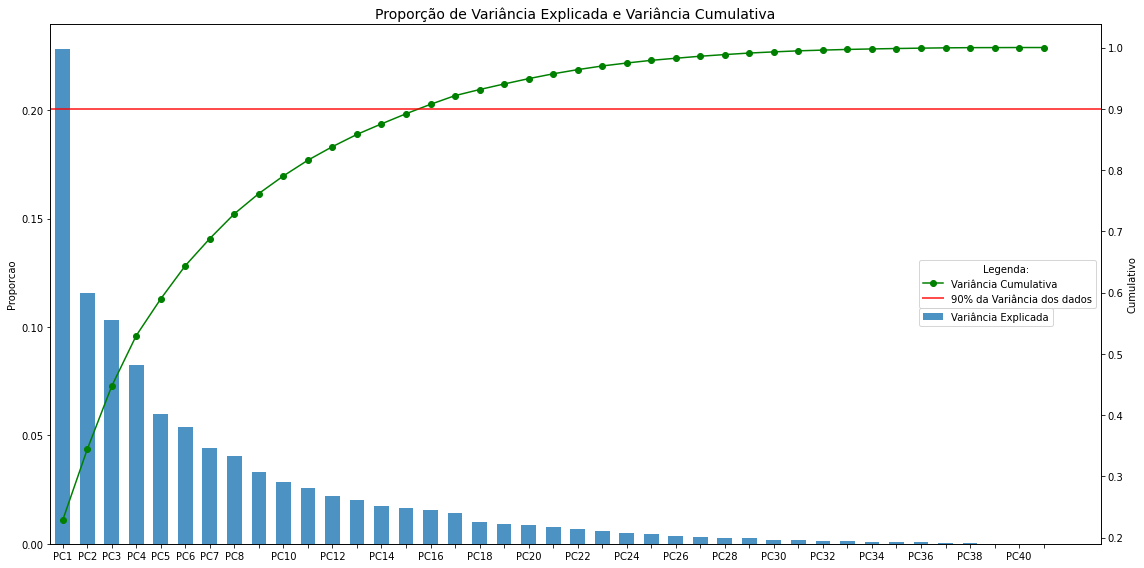

In [ ]:
fig, ax0, = plt.subplots(figsize=(16,8))

ax1 = ax0.twinx()

ax0.bar(x=variance_df['Principal Component'],height=variance_df['Proportion of Explained Variance'],
        width=0.6,
        alpha=0.8,
        label='Variância Explicada')
ax1.plot(variance_df['Principal Component'],variance_df['Cumulative Proportion of Variance'],
         'g-o',
         label='Variância Cumulativa')
ax1.axhline(0.90,
            color='red',
            lw=2,
            alpha=0.7,
            label='90% da Variância dos dados')
ax0.set_title('Proporção de Variância Explicada e Variância Cumulativa',fontdict={'fontsize':14})
ax0.set_ylabel('Proporcao')
ax0.set_xlim(left=-0.5)
ax1.set_ylabel('Cumulativo')



for label in ax0.get_xaxis().get_ticklabels()[8::2]:
    label.set_visible(False)  

#ax0.legend(loc='center right')
ax1.legend(loc='center right',title='Legenda: ')
ax0.legend(loc=[0.827,0.418])
plt.tight_layout()


In [ ]:
#Determinação da Matriz de Loading Factors para cada componente.
df_loading_factor = pd.DataFrame(pca.components_,index=X.columns,columns=lista_pcas)
df_loading_factor

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41
TEMP AR MEDIO,-0.312037,0.030697,0.045570,0.236926,-0.178999,-0.078633,0.032521,0.011105,-0.295501,-0.281641,...,0.009632,0.050661,-0.163305,0.111118,0.029891,0.013180,0.059892,-0.003022,-0.010308,0.039788
UMIDADE RLV,-0.044113,-0.311890,-0.248337,0.038746,0.221974,0.300965,-0.293075,-0.203711,-0.048390,-0.054755,...,0.024162,0.107994,-0.000927,0.089158,0.014120,0.078646,0.046178,0.120911,0.057557,0.138249
MOLHAMENTO FOLIAR MEDIO,0.041164,0.050732,0.218106,-0.004034,-0.034287,-0.167682,0.023822,-0.036149,0.077646,0.028108,...,-0.031041,0.339959,0.219554,0.003656,-0.019589,-0.117288,0.107072,0.062243,0.120913,0.403952
PRESSAO ATM MED,0.058241,0.219402,-0.145543,-0.048368,-0.215095,0.204417,-0.007057,0.327063,-0.066095,0.145584,...,0.055147,0.174753,0.024976,-0.005417,-0.040770,-0.076611,0.038379,-0.219959,-0.137574,0.135388
RADIACAO SOLAR MEDIA,-0.000513,0.045760,0.140674,-0.042294,-0.069345,0.128910,-0.037133,0.057151,-0.058323,0.060255,...,0.062309,-0.189722,-0.113293,0.058599,-0.468181,-0.293491,0.215805,0.251694,0.517860,0.003195
VEL MAX VENTO MEDIA,0.051575,0.237687,0.031835,0.121906,0.000929,-0.028229,0.062077,0.213899,-0.019198,0.131753,...,-0.078696,0.048082,-0.003236,0.076597,0.272476,0.055377,0.042455,-0.132439,-0.030883,0.024281
UMIDADE AR MAX,-0.080723,-0.063267,0.051746,0.011205,0.302633,-0.139398,0.257198,-0.265023,0.007893,-0.166065,...,0.056197,-0.040252,-0.005313,-0.081862,-0.057094,-0.266204,-0.110194,-0.248103,0.008750,-0.009567
UMIDADE AR MIN,0.078178,0.065793,-0.206758,0.080321,0.021000,-0.032855,0.144721,-0.001756,0.114182,0.057880,...,-0.281589,-0.061710,-0.445201,0.553164,0.026407,-0.262659,0.195619,-0.247437,0.095871,-0.029024
TEMP MAX,0.005188,-0.052502,-0.293139,0.088428,0.016714,-0.150122,-0.150663,-0.030555,-0.003821,0.010796,...,0.535092,0.114721,0.122601,-0.150936,-0.041365,-0.340224,0.410574,-0.157861,-0.041796,0.080286
TEMP MIN,-0.023076,0.214772,0.196931,-0.022268,0.122969,0.212848,0.274499,0.077057,0.039865,-0.074246,...,0.168442,0.219930,0.028553,0.077599,0.130609,-0.082431,0.192519,-0.077160,-0.115929,0.157141


In [ ]:
#Encontra a lista de parâmetros baseada no metodo do PCA

def ordena_max_loading_factor(serie):
  return serie.abs().sort_values(ascending=False).index

def encontra_lista_parametros(df_loading_factor):
  lista_parametros=[]
  for i,pca in enumerate(df_loading_factor.columns):

    if i==0:
      loading_list = ordena_max_loading_factor(df_loading_factor[pca])
      parameter = loading_list[0]
      lista_parametros.append(parameter)

    else:

      loading_list = ordena_max_loading_factor(df_loading_factor[pca])

      for i in range(len(loading_list)):
        parameter = loading_list[i]
        if parameter not in lista_parametros:
          lista_parametros.append(parameter)
          break
      

  return lista_parametros

In [ ]:
lista_parametros = encontra_lista_parametros(df_loading_factor)
# Para uma variancia explicada de 95%
lista_parametros[:20]

['Carr Org Sup g DQO/m2/d',
 'AFL_DQO',
 'AFL_pH',
 'PRECP ACUM 3d',
 'AFL_N-NO2-',
 'UMIDADE RLV',
 'MOLHAMENTO FOLIAR MEDIANO',
 'PRESSAO ATM MED',
 'AFL_N-NO3-',
 'AFL_N-NH4+',
 'AFL_SS',
 'TEMP AR 3d',
 'AFL_ALCALINIDADE',
 'AFL_STF',
 'VEL VENTO MAXIMA MAXIMA',
 'TEMP MIN',
 'TEMP AR MEDIO',
 'TEMP AR 7d',
 'VEL MAX VENTO MEDIA',
 'TEMP MEDIANA']

In [ ]:
# Cria um df para os parâmetros selecionados, contendo 90 % da variância explicada. 
df_pca = df[lista_parametros[:15]].copy()
df_pca.columns

Index(['Carr Org Sup g DQO/m2/d', 'AFL_DQO', 'AFL_pH', 'PRECP ACUM 3d',
       'AFL_N-NO2-', 'UMIDADE RLV', 'MOLHAMENTO FOLIAR MEDIANO',
       'PRESSAO ATM MED', 'AFL_N-NO3-', 'AFL_N-NH4+', 'AFL_SS', 'TEMP AR 3d',
       'AFL_ALCALINIDADE', 'AFL_STF', 'VEL VENTO MAXIMA MAXIMA'],
      dtype='object')

# Organizando os datasets de entrada na RNA

In [ ]:
# Dataset com as redução de variáveis atraves do PCA e do método B4
PCA_df_reduzido = df_pca.copy()
# PCA_df_reduzido.to_excel('/content/drive/MyDrive/TCC/dados_entrada/PCA_df_reduzido_13_11_2022.xlsx')

# Dataset transformado através do PCA para uma variância explicada de 90 % dos dados
PCA_df_95 = df_scores[df_scores.columns[:15]].copy()
# PCA_df_95.to_excel('/content/drive/MyDrive/TCC/dados_entrada/PCA_df_95_13_11_2022.xlsx')

# Dataset reduzido através do processo de escolha por arvóres de decisão
lista_cols_relevantes = ['AFL_N-NO3-','AFL_DQO','AFL_DBO',
                         'UMIDADE AR MIN','AFL_ALCALINIDADE','RAD SOLAR MEDIA 3d',
                         'AFL_SS','Fluxo L/m2/d','AFL_N-NO2-',
                         'UMIDADE AR MAX','TEMP MEDIANA','PRESSAO ATM MED',
                         'AFL_STV','VEL VENTO MAXIMA MAXIMA','AFL_pH','PRECP']
df_reduzido = df[lista_cols_relevantes].copy()
# df_reduzido.to_excel('/content/drive/MyDrive/TCC/dados_entrada/df_reduzido_boxcox_13_11_2022.xlsx')

In [ ]:
PCA_df_reduzido = df[lista_parametros[:20]]

PCA_df_reduzido.to_excel('/content/drive/MyDrive/TCC/dados_entrada/PCA_df_reduzido_normalizado_13_11_2022.xlsx')

# Redes Neurais Topologia

## Busca Melhor Topologia

### Dataset original

 - Normalizado por boxcox.

In [ ]:
X = df.drop(['EFL DQO'],axis=1)
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

############## 1 LAYER #############################
print()
print()
print('____________________')
print('RODANDO PARA 1 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios = [i for i in range(2,30)]

#RODA A ANN EM LOOP 
lista_hidden, lista_mse, lista_r2, lista_r2_ajust = run_ann_1layer(X_train,
                                                                   y_train,
                                                                   lista_neuronios,
                                                                   batch_sized=8,
                                                                   learning_rate=0.09,
                                                                   input_shape_GD =  input_dim,
                                                                   activation_func_intermd = 'relu',
                                                                   activation_func_output = 'linear'
                                                                   )

#Cria o df de resultados 
df_results_ANN_1ly = creates_df_ANN_results(lista_hidden, lista_mse, lista_r2, lista_r2_ajust)


################## 2 LAYER ###################################
print()
print()
print('____________________')
print('RODANDO PARA 2 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [4,8,12,16,20]
lista_neuronios_camada2 = [2,4,8,12]

#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 , lista_mse, lista_r2, lista_r2_ajust = run_ann_2layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_2ly = creates_df_ANN_results_2layer(lista_hidden_1, lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust)


##################### 3 LAYER ################################################
print()
print()
print('____________________')
print('RODANDO PARA 3 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [8,12,16,24]
lista_neuronios_camada2 = [4,8,16]
lista_neuronios_camada3 = [2,4,8]


#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 ,lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust = run_ann_3layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      lista_neuronios_3camada = lista_neuronios_camada3, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_3ly = creates_df_ANN_results_3layer(lista_hidden_1, lista_hidden_2, lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust)


print()
print()
# Mostra os resultados
df_original_uniao_resultados = cria_df_resultados_ANN(df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly)

RODANDO PARA 1 LAYER


Rodando para 2  neuronios na camada
1/1 [==============================] - 0s 81ms/step
Rodando para 3  neuronios na camada
1/1 [==============================] - 0s 50ms/step
Rodando para 4  neuronios na camada
1/1 [==============================] - 0s 59ms/step
Rodando para 5  neuronios na camada
1/1 [==============================] - 0s 44ms/step
Rodando para 6  neuronios na camada
1/1 [==============================] - 0s 51ms/step
Rodando para 7  neuronios na camada
1/1 [==============================] - 0s 63ms/step
Rodando para 8  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 9  neuronios na camada
1/1 [==============================] - 0s 75ms/step
Rodando para 10  neuronios na camada
1/1 [==============================] - 0s 52ms/step
Rodando para 11  neuronios na camada
1/1 [==============================] - 0s 51ms/step
Rodando para 12  neuronios na camada
1/1 [==============================] - 0s 53ms/step
Rodand

In [ ]:
df_original_uniao_resultados

,Numero de Neuronios 1 camada,Numero de Neuronios 2 camada,Numero de Neuronios 3 camada,Mean Squared Error,R2,R2 ajustado
22,16,8,4,154.458377,0.887838,0.788256
34,24,16,4,173.029658,0.874352,0.764492
27,29,-,-,175.451768,0.872593,0.761419
3,8,8,2,180.930936,0.868614,0.754491
26,16,16,8,192.154260,0.860464,0.740399
...,...,...,...,...,...,...
24,26,-,-,615.775428,0.552846,0.305639
0,8,4,2,618.287183,0.551022,0.303625
9,12,4,2,2737.602408,-0.987949,0.976042
8,12,2,-,2737.602408,-0.987949,0.976042


### Dataset Reduzido

- Parametros normalizados por boxcox

In [ ]:
X = df_reduzido
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

############## 1 LAYER #############################
print()
print()
print('____________________')
print('RODANDO PARA 1 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios = [i for i in range(2,30)]

#RODA A ANN EM LOOP 
lista_hidden, lista_mse, lista_r2, lista_r2_ajust = run_ann_1layer(X_train,
                                                                   y_train,
                                                                   lista_neuronios,
                                                                   batch_sized=8,
                                                                   learning_rate=0.09,
                                                                   input_shape_GD =  input_dim,
                                                                   activation_func_intermd = 'relu',
                                                                   activation_func_output = 'linear'
                                                                   )

#Cria o df de resultados 
df_results_ANN_1ly = creates_df_ANN_results(lista_hidden, lista_mse, lista_r2, lista_r2_ajust)


################## 2 LAYER ###################################
print()
print()
print('____________________')
print('RODANDO PARA 2 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [4,8,12,16,20]
lista_neuronios_camada2 = [2,4,8,12]

#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 , lista_mse, lista_r2, lista_r2_ajust = run_ann_2layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_2ly = creates_df_ANN_results_2layer(lista_hidden_1, lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust)


##################### 3 LAYER ################################################
print()
print()
print('____________________')
print('RODANDO PARA 3 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [8,12,16,24]
lista_neuronios_camada2 = [4,8,16]
lista_neuronios_camada3 = [2,4,8]


#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 ,lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust = run_ann_3layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      lista_neuronios_3camada = lista_neuronios_camada3, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_3ly = creates_df_ANN_results_3layer(lista_hidden_1, lista_hidden_2, lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust)


print()
print()
# Mostra os resultados
df_original_uniao_resultados = cria_df_resultados_ANN(df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly)



____________________
RODANDO PARA 1 LAYER


Rodando para 2  neuronios na camada
1/1 [==============================] - 0s 76ms/step
Rodando para 3  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 4  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 5  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 6  neuronios na camada
1/1 [==============================] - 0s 52ms/step
Rodando para 7  neuronios na camada
1/1 [==============================] - 0s 49ms/step
Rodando para 8  neuronios na camada
1/1 [==============================] - 0s 55ms/step
Rodando para 9  neuronios na camada
1/1 [==============================] - 0s 47ms/step
Rodando para 10  neuronios na camada
1/1 [==============================] - 0s 48ms/step
Rodando para 11  neuronios na camada
1/1 [==============================] - 0s 52ms/step
Rodando para 12  neuronios na camada
1/1 [==============================

In [ ]:
df_original_uniao_resultados.tail()

,Numero de Neuronios 1 camada,Numero de Neuronios 2 camada,Numero de Neuronios 3 camada,Mean Squared Error,R2,R2 ajustado
26,16,16,8,206.803757,0.849827,0.722205
35,24,16,8,212.525758,0.845671,0.715160
8,8,16,8,214.178634,0.844471,0.713132
25,16,16,4,236.089971,0.828560,0.686512
0,4,2,-,254.324924,0.815318,0.664744
...,...,...,...,...,...,...
9,12,4,2,2737.602408,-0.987949,0.976042
7,8,16,4,2737.602408,-0.987949,0.976042
3,8,8,2,2737.602408,-0.987949,0.976042
16,20,2,-,2737.602408,-0.987949,0.976042





### Dataset CP 90

In [ ]:
X = PCA_df_95
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

############## 1 LAYER #############################
print()
print()
print('____________________')
print('RODANDO PARA 1 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios = [i for i in range(2,30)]

#RODA A ANN EM LOOP 
lista_hidden, lista_mse, lista_r2, lista_r2_ajust = run_ann_1layer(X_train,
                                                                   y_train,
                                                                   lista_neuronios,
                                                                   batch_sized=8,
                                                                   learning_rate=0.09,
                                                                   input_shape_GD =  input_dim,
                                                                   activation_func_intermd = 'relu',
                                                                   activation_func_output = 'linear'
                                                                   )

#Cria o df de resultados 
df_results_ANN_1ly = creates_df_ANN_results(lista_hidden, lista_mse, lista_r2, lista_r2_ajust)


################## 2 LAYER ###################################
print()
print()
print('____________________')
print('RODANDO PARA 2 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [4,8,12,16,20]
lista_neuronios_camada2 = [2,4,8,12]

#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 , lista_mse, lista_r2, lista_r2_ajust = run_ann_2layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_2ly = creates_df_ANN_results_2layer(lista_hidden_1, lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust)


##################### 3 LAYER ################################################
print()
print()
print('____________________')
print('RODANDO PARA 3 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [8,12,16,24]
lista_neuronios_camada2 = [4,8,16]
lista_neuronios_camada3 = [2,4,8]


#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 ,lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust = run_ann_3layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      lista_neuronios_3camada = lista_neuronios_camada3, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_3ly = creates_df_ANN_results_3layer(lista_hidden_1, lista_hidden_2, lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust)


print()
print()
# Mostra os resultados
df_original_uniao_resultados = cria_df_resultados_ANN(df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly)



____________________
RODANDO PARA 1 LAYER


Rodando para 2  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 3  neuronios na camada
1/1 [==============================] - 0s 58ms/step
Rodando para 4  neuronios na camada
1/1 [==============================] - 0s 53ms/step
Rodando para 5  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 6  neuronios na camada
1/1 [==============================] - 0s 86ms/step
Rodando para 7  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 8  neuronios na camada
1/1 [==============================] - 0s 48ms/step
Rodando para 9  neuronios na camada
1/1 [==============================] - 0s 77ms/step
Rodando para 10  neuronios na camada
1/1 [==============================] - 0s 44ms/step
Rodando para 11  neuronios na camada
1/1 [==============================] - 0s 50ms/step
Rodando para 12  neuronios na camada
1/1 [==============================

In [ ]:
df_original_uniao_resultados

,Numero de Neuronios 1 camada,Numero de Neuronios 2 camada,Numero de Neuronios 3 camada,Mean Squared Error,R2,R2 ajustado
12,16,2,-,233.431841,0.830490,0.689714
1,4,4,-,292.159593,0.787844,0.620698
34,24,16,4,294.032075,0.786484,0.618558
14,16,-,-,294.811072,0.785919,0.617668
2,4,8,-,308.905747,0.775684,0.601685
...,...,...,...,...,...,...
23,16,8,8,2737.602408,-0.987949,0.976042
20,16,4,8,2737.602408,-0.987949,0.976042
13,12,8,4,2737.602408,-0.987949,0.976042
6,8,8,-,2737.602408,-0.987949,0.976042


### Dataset CP Reduzido

In [ ]:
len(PCA_df_reduzido.columns)

20

In [ ]:
X = PCA_df_reduzido
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

############## 1 LAYER #############################
print()
print()
print('____________________')
print('RODANDO PARA 1 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios = [i for i in range(2,30)]

#RODA A ANN EM LOOP 
lista_hidden, lista_mse, lista_r2, lista_r2_ajust = run_ann_1layer(X_train,
                                                                   y_train,
                                                                   lista_neuronios,
                                                                   batch_sized=8,
                                                                   learning_rate=0.09,
                                                                   input_shape_GD =  input_dim,
                                                                   activation_func_intermd = 'relu',
                                                                   activation_func_output = 'linear'
                                                                   )

#Cria o df de resultados 
df_results_ANN_1ly = creates_df_ANN_results(lista_hidden, lista_mse, lista_r2, lista_r2_ajust)


################## 2 LAYER ###################################
print()
print()
print('____________________')
print('RODANDO PARA 2 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [4,8,12,16,20]
lista_neuronios_camada2 = [2,4,8,12]

#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 , lista_mse, lista_r2, lista_r2_ajust = run_ann_2layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_2ly = creates_df_ANN_results_2layer(lista_hidden_1, lista_hidden_2, lista_mse, lista_r2, lista_r2_ajust)


##################### 3 LAYER ################################################
print()
print()
print('____________________')
print('RODANDO PARA 3 LAYER')
print()
print()

#LISTA DE NEURONIOS A SER PROCURADO 
lista_neuronios_camada1 = [8,12,16,24]
lista_neuronios_camada2 = [4,8,16]
lista_neuronios_camada3 = [2,4,8]


#RODA A ANN EM LOOP 
lista_hidden_1, lista_hidden_2 ,lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust = run_ann_3layer(X_train,
                                                                                      y_train,
                                                                                      lista_neuronios_1camada = lista_neuronios_camada1,
                                                                                      lista_neuronios_2camada = lista_neuronios_camada2, 
                                                                                      lista_neuronios_3camada = lista_neuronios_camada3, 
                                                                                      batch_sized = 8,
                                                                                      learning_rate=0.09,
                                                                                      input_shape_GD =  input_dim,
                                                                                      activation_func_intermd = 'relu',
                                                                                      activation_func_output = 'linear'
                                                                                      )

#Cria o df de resultados 
df_results_ANN_3ly = creates_df_ANN_results_3layer(lista_hidden_1, lista_hidden_2, lista_hidden_3, lista_mse, lista_r2, lista_r2_ajust)


print()
print()
# Mostra os resultados
df_original_uniao_resultados = cria_df_resultados_ANN(df_results_ANN_1ly,df_results_ANN_2ly,df_results_ANN_3ly)



____________________
RODANDO PARA 1 LAYER


Rodando para 2  neuronios na camada
1/1 [==============================] - 0s 44ms/step
Rodando para 3  neuronios na camada
1/1 [==============================] - 0s 43ms/step
Rodando para 4  neuronios na camada
1/1 [==============================] - 0s 49ms/step
Rodando para 5  neuronios na camada
1/1 [==============================] - 0s 43ms/step
Rodando para 6  neuronios na camada
1/1 [==============================] - 0s 42ms/step
Rodando para 7  neuronios na camada
1/1 [==============================] - 0s 46ms/step
Rodando para 8  neuronios na camada
1/1 [==============================] - 0s 72ms/step
Rodando para 9  neuronios na camada
1/1 [==============================] - 0s 43ms/step
Rodando para 10  neuronios na camada
1/1 [==============================] - 0s 43ms/step
Rodando para 11  neuronios na camada
1/1 [==============================] - 0s 45ms/step
Rodando para 12  neuronios na camada
1/1 [==============================

In [ ]:
df_original_uniao_resultados

,Numero de Neuronios 1 camada,Numero de Neuronios 2 camada,Numero de Neuronios 3 camada,Mean Squared Error,R2,R2 ajustado
0,4,2,-,479.665497,0.651684,0.424692
25,16,16,4,553.616684,0.597983,0.357584
10,12,8,-,569.087252,0.586749,0.344275
0,8,4,2,591.883675,0.570195,0.325123
9,12,4,-,630.950865,0.541826,0.293576
...,...,...,...,...,...,...
27,29,-,-,1467.467911,-0.065623,0.004306
16,12,16,4,1483.101825,-0.076975,0.005925
1,8,4,4,2737.602408,-0.987949,0.976042
28,24,4,4,2737.602408,-0.987949,0.976042


## RNA - Dataset Original

In [ ]:
X = df.drop(['EFL DQO'],axis=1)
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

#Constroi o modelo
model_df_original = build_model_3layer(
                                      n_neurons_1=32,
                                      n_neurons_2=16,
                                      n_neurons_3=8,
                                      learning_rate=0.09,
                                      input_shape=input_dim,
                                      act_func_intermd = 'relu',
                                      act_func_output='linear'
                                      )

# Adiciona EarlyStopping para evitar overfitting
early_stopping = callbacks.EarlyStopping(
    #monitor='val_mean_squared_error'
    #monitor='val_loss',
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True )


#Divide a base de treino para realização de teste enquanto o modelo é fitado  
X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)

model_df_original.fit(X_train_train,
                      y_train_train,
                      batch_size = 10,
                      epochs =1000,
                      callbacks=[early_stopping],
                      validation_data=(X_test_test,y_test_test),
                      verbose=2
)


#Predict 
y_pred = model_df_original.predict(X_test)

y_pred = y_pred.reshape(1,-1)[0]

#df resultados
df_results = create_df_results(y_test,y_pred)
df_results_df_original = df_results.copy()

#Print results
mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=True)

create_plot_predict(df_results,y_test,y_pred)

Epoch 1/1000
6/6 - 1s - loss: 1297.7944 - mean_squared_error: 1297.7944 - val_loss: 1718.5911 - val_mean_squared_error: 1718.5911 - 767ms/epoch - 128ms/step
Epoch 2/1000
6/6 - 0s - loss: 380.2562 - mean_squared_error: 380.2562 - val_loss: 2157.3279 - val_mean_squared_error: 2157.3279 - 49ms/epoch - 8ms/step
Epoch 3/1000
6/6 - 0s - loss: 349.6048 - mean_squared_error: 349.6048 - val_loss: 1140.4313 - val_mean_squared_error: 1140.4313 - 43ms/epoch - 7ms/step
Epoch 4/1000
6/6 - 0s - loss: 198.7089 - mean_squared_error: 198.7089 - val_loss: 1288.0588 - val_mean_squared_error: 1288.0587 - 45ms/epoch - 8ms/step
Epoch 5/1000
6/6 - 0s - loss: 170.2974 - mean_squared_error: 170.2974 - val_loss: 1591.2009 - val_mean_squared_error: 1591.2009 - 42ms/epoch - 7ms/step
Epoch 6/1000
6/6 - 0s - loss: 94.7769 - mean_squared_error: 94.7769 - val_loss: 1474.0521 - val_mean_squared_error: 1474.0522 - 74ms/epoch - 12ms/step
Epoch 7/1000
6/6 - 0s - loss: 62.5668 - mean_squared_error: 62.5668 - val_loss: 1414

In [ ]:
df_results.to_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_original.xlsx')
model_df_original.save('/content/drive/MyDrive/TCC/MODELS_ANN/model_df_original.h5')

## RNA DATASET REDUZIDO

In [ ]:
X = df_reduzido
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

#Constroi o modelo
model_df_original = build_model_3layer(
                                      n_neurons_1=16,
                                      n_neurons_2=16,
                                      n_neurons_3=8,
                                      learning_rate=0.09,
                                      input_shape=input_dim,
                                      act_func_intermd = 'relu',
                                      act_func_output='linear'
                                      )

# Adiciona EarlyStopping para evitar overfitting
early_stopping = callbacks.EarlyStopping(
    #monitor='val_mean_squared_error'
    #monitor='val_loss',
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True )


#Divide a base de treino para realização de teste enquanto o modelo é fitado  
X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)

model_df_original.fit(X_train_train,
                      y_train_train,
                      batch_size = 9,
                      epochs =1000,
                      callbacks=[early_stopping],
                      validation_data=(X_test_test,y_test_test),
                      verbose=2
)


#Predict 
y_pred = model_df_original.predict(X_test)

y_pred = y_pred.reshape(1,-1)[0]

#df resultados
df_results = create_df_results(y_test,y_pred)
df_results_df_reduzido = df_results.copy()

#Print results
mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=True)

#Imprime os resultados
create_plot_predict(df_results,y_test,y_pred)

Epoch 1/1000
7/7 - 1s - loss: 1536.4723 - mean_squared_error: 1536.4723 - val_loss: 2065.9351 - val_mean_squared_error: 2065.9351 - 776ms/epoch - 111ms/step
Epoch 2/1000
7/7 - 0s - loss: 944.4075 - mean_squared_error: 944.4075 - val_loss: 2053.0312 - val_mean_squared_error: 2053.0312 - 48ms/epoch - 7ms/step
Epoch 3/1000
7/7 - 0s - loss: 767.3833 - mean_squared_error: 767.3833 - val_loss: 2207.6667 - val_mean_squared_error: 2207.6667 - 74ms/epoch - 11ms/step
Epoch 4/1000
7/7 - 0s - loss: 504.3842 - mean_squared_error: 504.3842 - val_loss: 1598.7278 - val_mean_squared_error: 1598.7278 - 75ms/epoch - 11ms/step
Epoch 5/1000
7/7 - 0s - loss: 430.7560 - mean_squared_error: 430.7560 - val_loss: 1299.3572 - val_mean_squared_error: 1299.3572 - 48ms/epoch - 7ms/step
Epoch 6/1000
7/7 - 0s - loss: 280.6025 - mean_squared_error: 280.6025 - val_loss: 1246.4690 - val_mean_squared_error: 1246.4690 - 63ms/epoch - 9ms/step
Epoch 7/1000
7/7 - 0s - loss: 342.6105 - mean_squared_error: 342.6105 - val_loss:

In [ ]:
df_results_df_reduzido.to_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_reduzido.xlsx')
model_df_original.save('/content/drive/MyDrive/TCC/MODELS_ANN/model_df_reduzido.h5')

## RNA - DATASET CP 95

In [ ]:
X = PCA_df_95
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

#Constroi o modelo
model_df_original = build_model_3layer(
                                      n_neurons_1=16,
                                      n_neurons_2=16,
                                      n_neurons_3=8,
                                      learning_rate=0.09,
                                      input_shape=input_dim,
                                      act_func_intermd = 'relu',
                                      act_func_output='linear'
                                      )

# Adiciona EarlyStopping para evitar overfitting
early_stopping = callbacks.EarlyStopping(
    #monitor='val_mean_squared_error'
    #monitor='val_loss',
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True )


#Divide a base de treino para realização de teste enquanto o modelo é fitado  
X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)

model_df_original.fit(X_train_train,
                      y_train_train,
                      batch_size = 8,
                      epochs =1000,
                      callbacks=[early_stopping],
                      validation_data=(X_test_test,y_test_test),
                      verbose=2
)


#Predict 
y_pred = model_df_original.predict(X_test)

y_pred = y_pred.reshape(1,-1)[0]

#df resultados
df_results = create_df_results(y_test,y_pred)
df_results_df_CP_95 = df_results.copy()

#Print results
mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=True)

#Imprime os resultados
create_plot_predict(df_results,y_test,y_pred)

Epoch 1/1000
8/8 - 1s - loss: 1573.9335 - mean_squared_error: 1573.9335 - val_loss: 949.3698 - val_mean_squared_error: 949.3698 - 780ms/epoch - 97ms/step
Epoch 2/1000
8/8 - 0s - loss: 473.4224 - mean_squared_error: 473.4224 - val_loss: 775.8586 - val_mean_squared_error: 775.8586 - 51ms/epoch - 6ms/step
Epoch 3/1000
8/8 - 0s - loss: 535.0967 - mean_squared_error: 535.0967 - val_loss: 1342.8289 - val_mean_squared_error: 1342.8289 - 66ms/epoch - 8ms/step
Epoch 4/1000
8/8 - 0s - loss: 1023.3203 - mean_squared_error: 1023.3203 - val_loss: 1590.1475 - val_mean_squared_error: 1590.1475 - 71ms/epoch - 9ms/step
Epoch 5/1000
8/8 - 0s - loss: 448.9506 - mean_squared_error: 448.9506 - val_loss: 789.6469 - val_mean_squared_error: 789.6469 - 53ms/epoch - 7ms/step
Epoch 6/1000
8/8 - 0s - loss: 394.7253 - mean_squared_error: 394.7253 - val_loss: 1521.2913 - val_mean_squared_error: 1521.2913 - 66ms/epoch - 8ms/step
Epoch 7/1000
8/8 - 0s - loss: 546.9774 - mean_squared_error: 546.9774 - val_loss: 1246.1

In [ ]:
df_results_df_CP_95.to_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_cp_95.xlsx')
model_df_original.save('/content/drive/MyDrive/TCC/MODELS_ANN/model_df_cp_95.h5')

## RNA - DATASET CP Reduzido

In [ ]:
X = PCA_df_reduzido
y = df_original['EFL DQO']

# DIVIDE O CONJUNTO DE DADOS ENTRE TREINO E TESTE
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

#PRE PROCESSAMENTO  - PARAMETRIZAÇÃO
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

#INSERE UMA SEED PARA GERAR AS MESMAS DIVISOES 
seed=20
input_dim = len(X_train[0])

#Constroi o modelo
model_df_original = build_model_3layer(
                                      n_neurons_1=16,
                                      n_neurons_2=16,
                                      n_neurons_3=8,
                                      learning_rate=0.09,
                                      input_shape=input_dim,
                                      act_func_intermd = 'relu',
                                      act_func_output='linear'
                                      )

# Adiciona EarlyStopping para evitar overfitting
early_stopping = callbacks.EarlyStopping(
    #monitor='val_mean_squared_error'
    #monitor='val_loss',
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True )


#Divide a base de treino para realização de teste enquanto o modelo é fitado  
X_train_train, X_test_test, y_train_train, y_test_test = train_test_split(X_train, y_train, test_size=0.25, random_state=20)

model_df_original.fit(X_train_train,
                      y_train_train,
                      batch_size = 8,
                      epochs =1000,
                      callbacks=[early_stopping],
                      validation_data=(X_test_test,y_test_test),
                      verbose=2
)


#Predict 
y_pred = model_df_original.predict(X_test)

y_pred = y_pred.reshape(1,-1)[0]

#df resultados
df_results = create_df_results(y_test,y_pred)
df_results_df_CP_95 = df_results.copy()

#Print results
mean_sqr_error, r2_scor, r2_ajust = print_metrics(y_test,y_pred,retur=True,printed=True)

#Imprime os resultados
create_plot_predict(df_results,y_test,y_pred)

Epoch 1/1000
8/8 - 1s - loss: 1470.3350 - mean_squared_error: 1470.3350 - val_loss: 2267.8098 - val_mean_squared_error: 2267.8098 - 1s/epoch - 161ms/step
Epoch 2/1000
8/8 - 0s - loss: 864.1078 - mean_squared_error: 864.1078 - val_loss: 2732.2881 - val_mean_squared_error: 2732.2881 - 67ms/epoch - 8ms/step
Epoch 3/1000
8/8 - 0s - loss: 815.4128 - mean_squared_error: 815.4128 - val_loss: 2754.9563 - val_mean_squared_error: 2754.9563 - 105ms/epoch - 13ms/step
Epoch 4/1000
8/8 - 0s - loss: 641.3464 - mean_squared_error: 641.3464 - val_loss: 2412.1860 - val_mean_squared_error: 2412.1860 - 78ms/epoch - 10ms/step
Epoch 5/1000
8/8 - 0s - loss: 357.9763 - mean_squared_error: 357.9763 - val_loss: 1930.5283 - val_mean_squared_error: 1930.5283 - 76ms/epoch - 10ms/step
Epoch 6/1000
8/8 - 0s - loss: 322.3323 - mean_squared_error: 322.3323 - val_loss: 2174.1128 - val_mean_squared_error: 2174.1128 - 107ms/epoch - 13ms/step
Epoch 7/1000
8/8 - 0s - loss: 239.7854 - mean_squared_error: 239.7854 - val_loss

In [ ]:
df_results_df_CP_95.to_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_cp_reduzido.xlsx')
model_df_original.save('/content/drive/MyDrive/TCC/MODELS_ANN/model_df_cp_reduzido.h5')

In [ ]:
y_test.values

array([ 16.275,  24.96 ,  39.   ,  81.   , 120.   ,  37.91 ,  42.86 ,
         9.6  ,  12.345, 183.   ,  24.12 ,  27.285,  19.68 ,  13.9  ,
        29.55 ,  34.815,  41.45 ,  14.1  ,  24.51 ,  21.2  ,  16.7  ,
         6.35 ,  27.7  ,  33.   ,  28.22 ,  29.48 ])

## Plot dos Resultados

In [ ]:
df_results_original = pd.read_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_original.xlsx')
df_results_reduzido = pd.read_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_reduzido.xlsx')
df_results_df_CP_95 = pd.read_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_cp_95.xlsx')
df_results_df_CP_reduzido = pd.read_excel('/content/drive/MyDrive/TCC/dados_entrada/RESULTADOS_df_cp_reduzido.xlsx')

In [ ]:
df_results_original = pd.DataFrame(df_results_original.values, index=df_results_original['y_test'].values,columns=df_results_original.columns).reindex(y_test).reset_index(drop=True)
df_results_reduzido = pd.DataFrame(df_results_reduzido.values, index=df_results_reduzido['y_test'].values,columns=df_results_reduzido.columns).reindex(y_test).reset_index(drop=True)
df_results_df_CP_95 = pd.DataFrame(df_results_df_CP_95.values, index=df_results_df_CP_95['y_test'].values,columns=df_results_df_CP_95.columns).reindex(y_test).reset_index(drop=True)
df_results_df_CP_reduzido = pd.DataFrame(df_results_df_CP_reduzido.values, index=df_results_df_CP_reduzido['y_test'].values,columns=df_results_df_CP_reduzido.columns).reindex(y_test).reset_index(drop=True)

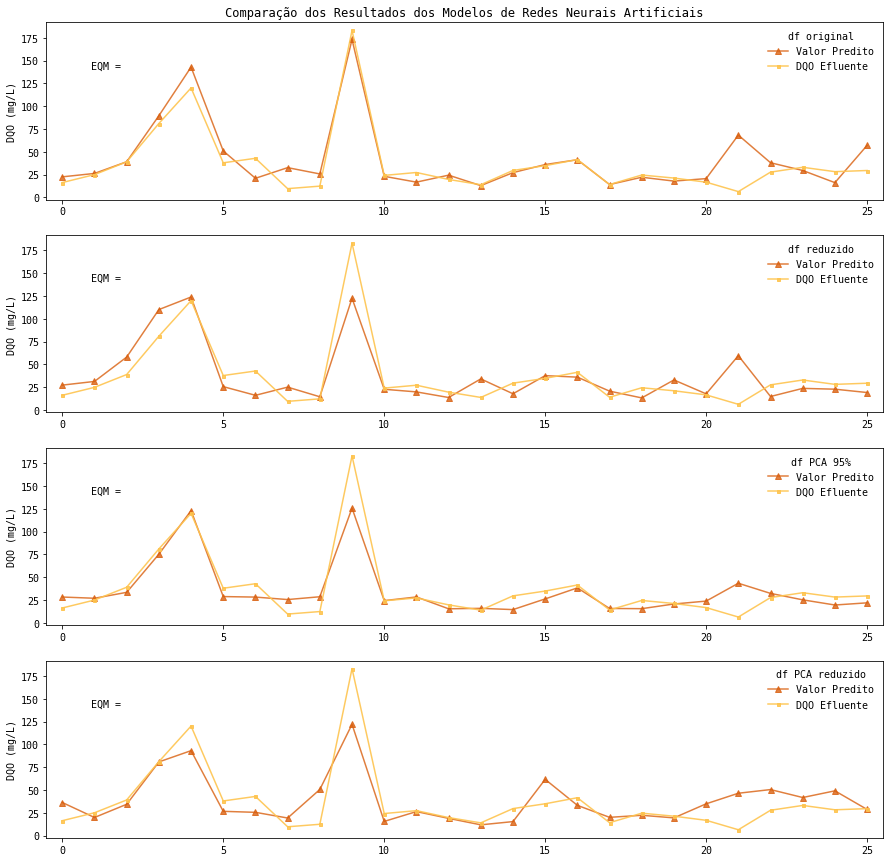

In [ ]:
import matplotlib 

#Fonte
#define font family to use for all text
matplotlib.rcParams['font.family'] = 'monospace'

#Create Figure
fig, axs = plt.subplots(4, 1,figsize=(15,15))


######################################## 1 ###########################################################################


#Create Plots
line_main1 = axs[0].plot(df_results_original.index, df_results_original['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main2 = axs[0].plot(df_results_original.index, df_results_original['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')


#Labels
#axs[0].set_xlabel('Data')
axs[0].set_ylabel('DQO (mg/L)')


#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[0].set_xlim(df_results_original.index.min()-.5,df_results_original.index.max()+.5)
### Y
#axs[0].set_ylim(0, df['AFL_DQO'].max()+100)


#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[0].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
axs[0].xaxis.grid(False,which='minor')


#Title
axs[0].set_title('Comparação dos Resultados dos Modelos de Redes Neurais Artificiais')


#Legend
axs[0].legend([line_main1[0],line_main2[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title= 'df original',
              frameon=False)

# Comentario
axs[0].annotate('EQM = ', xy=(2,150),
            horizontalalignment='right', verticalalignment='top'
            )

############################################ 2 ##################################################################


#Create Plots
line_main11 = axs[1].plot(df_results_reduzido.index, df_results_reduzido['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main12 = axs[1].plot(df_results_reduzido.index, df_results_reduzido['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels

axs[1].set_ylabel('DQO (mg/L)')


#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[1].set_xlim(df_results_reduzido.index.min()-.5,df_results_reduzido.index.max()+.5)
### Y
#axs[1].set_ylim(0, df['AFL_N-NH4+'].max()+10)


#Minor Axis
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[1].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[1].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[1].legend([line_main11[0],line_main12[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df reduzido',
              frameon=False)

# Comentario
axs[1].annotate('EQM = ', xy=(2,150),
            horizontalalignment='right', verticalalignment='top'
            )
#fig.tight_layout()
######################################### 3 ###################################################################



#Create Plots

line_main21 = axs[2].plot(df_results_df_CP_95.index, df_results_df_CP_95['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main22 = axs[2].plot(df_results_df_CP_95.index, df_results_df_CP_95['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels
#axs[0].set_xlabel('Data')
axs[2].set_ylabel('DQO (mg/L)')

#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[2].set_xlim(df_results_df_CP_95.index.min()-0.5, df_results_df_CP_95.index.max()+0.5)
### Y
#axs[2].set_ylim(0, df['AFL_P-PO43-'].max()+10)


#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[2].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[2].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[2].legend([line_main21[0],line_main22[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df PCA 95%',
              frameon=False)

# Comentario
axs[2].annotate('EQM = ', xy=(2,150),
            horizontalalignment='right', verticalalignment='top'
            )
###################### 4 ########################################################


line_main31 = axs[3].plot(df_results_df_CP_reduzido.index, df_results_df_CP_reduzido['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main32 = axs[3].plot(df_results_df_CP_reduzido.index, df_results_df_CP_reduzido['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels
#axs[0].set_xlabel('Data')
axs[3].set_ylabel('DQO (mg/L)')

#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[3].set_xlim(df_results_df_CP_reduzido.index.min()-0.5, df_results_df_CP_reduzido.index.max()+0.5)
### Y
#axs[2].set_ylim(0, df['AFL_P-PO43-'].max()+10)


#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[2].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[2].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[3].legend([line_main31[0],line_main32[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df PCA reduzido',
              frameon=False)

axs[3].annotate('EQM = ', xy=(2,150),
            horizontalalignment='right', verticalalignment='top'
            )

plt.show()

Text(10, 150, 'R² ajustado= ')

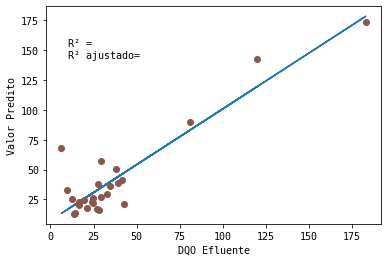

In [ ]:
# fit a linear curve an estimate its y-values and their error.
x = df_results_original['y_test']
y = df_results_original['pred']

a, b = np.polyfit(x, y, deg=1)
y_est = a*x+b

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')

ax.set_ylabel('Valor Predito')
ax.set_xlabel('DQO Efluente')

ax.annotate('R² = ', xy=(10,160),
            horizontalalignment='left', verticalalignment='top'
            )
ax.annotate('R² ajustado= ', xy=(10,150),
            horizontalalignment='left', verticalalignment='top'
            )

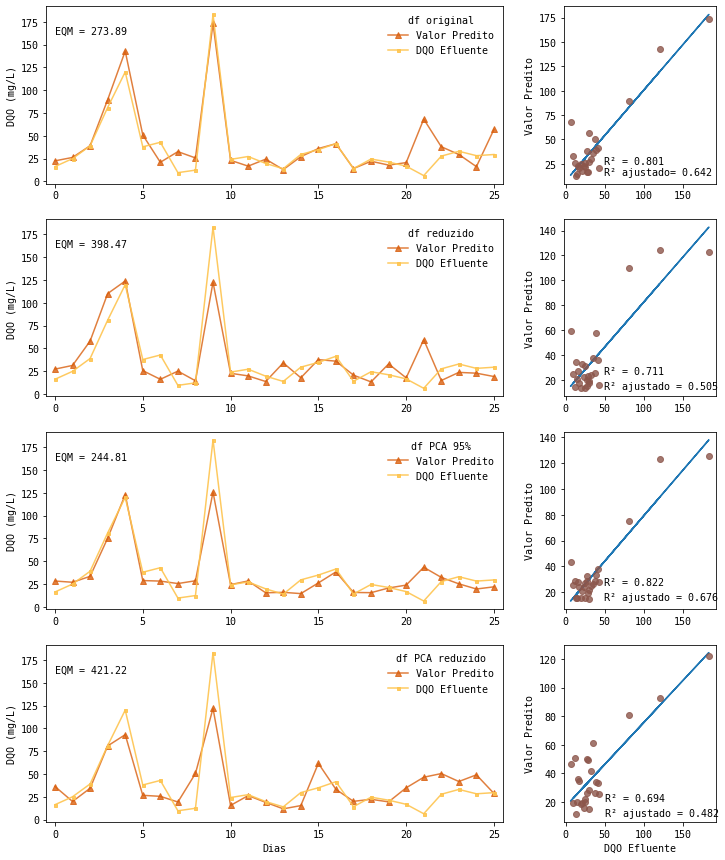

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 15),
                       gridspec_kw={
                           'width_ratios': [3, 1],
                           'height_ratios': [1, 1,1,1],
                       'wspace': 0.2,
                       'hspace': 0.2})

################################### Camada 1 ################################################################
# ax[0][0] will take 0th position in
line_main1 = axs[0][0].plot(df_results_original.index, df_results_original['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main2 = axs[0][0].plot(df_results_original.index, df_results_original['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels
axs[0][0].set_ylabel('DQO (mg/L)')


#Limits
### X
axs[0][0].set_xlim(df_results_original.index.min()-.5,df_results_original.index.max()+.5)
### Y
#axs[0].set_ylim(0, df['AFL_DQO'].max()+100)

#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[0].xaxis.set_minor_locator(MultipleLocator(120))

#Grid
axs[0][0].xaxis.grid(False,which='minor')

#Title
#axs[0].set_title('Comparação dos Resultados dos Modelos de Redes Neurais Artificiais')

#Legend
axs[0][0].legend([line_main1[0],line_main2[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title= 'df original',
              frameon=False)

# Comentario
axs[0][0].annotate('EQM = 273.89', xy=(0,170),
            horizontalalignment='left', verticalalignment='top'
            ) 

####### ax[0] posicao 1 ###################### 
x = df_results_original['y_test'].values
y = df_results_original['pred'].values
a, b = np.polyfit(x, y, deg=1)
y_est = a*x+b

axs[0][1].plot(x, y_est, '-')
axs[0][1].plot(x, y, 'o', color='tab:brown',alpha=0.8)

axs[0][1].set_ylabel('Valor Predito')
#axs[0][1].set_xlabel('DQO Efluente')

axs[0][1].annotate('R² = 0.801', xy=(49,33),
            horizontalalignment='left', verticalalignment='top'
            )
axs[0][1].annotate('R² ajustado= 0.642', xy=(49,22),
            horizontalalignment='left', verticalalignment='top'
            )


################################### Camada 2  #####################################################################
# ax[0][0] will take 0th position in
# geometry(Grid we created for subplots)

#Create Plots
line_main11 = axs[1][0].plot(df_results_reduzido.index, df_results_reduzido['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main12 = axs[1][0].plot(df_results_reduzido.index, df_results_reduzido['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels

axs[1][0].set_ylabel('DQO (mg/L)')


#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[1][0].set_xlim(df_results_reduzido.index.min()-.5,df_results_reduzido.index.max()+.5)
### Y
#axs[1].set_ylim(0, df['AFL_N-NH4+'].max()+10)


#Minor Axis
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[1].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[1].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[1][0].legend([line_main11[0],line_main12[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df reduzido',
              frameon=False)

# Comentario
axs[1][0].annotate('EQM = 398.47', xy=(0,170),
            horizontalalignment='left', verticalalignment='top'
            ) 

####### ax[1] posicao 1 ###################### 
x = df_results_reduzido['y_test'].values
y = df_results_reduzido['pred'].values
a, b = np.polyfit(x, y, deg=1)
y_est = a*x+b

axs[1][1].plot(x, y_est, '-')
axs[1][1].plot(x, y, 'o', color='tab:brown',alpha=0.8)

axs[1][1].set_ylabel('Valor Predito')
#axs[1][1].set_xlabel('DQO Efluente')

axs[1][1].annotate('R² = 0.711', xy=(49,31),
            horizontalalignment='left', verticalalignment='top'
            )
axs[1][1].annotate('R² ajustado = 0.505', xy=(49,19),
            horizontalalignment='left', verticalalignment='top'
            )

######################################### Camada 3 #########################################################################

line_main21 = axs[2][0].plot(df_results_df_CP_95.index, df_results_df_CP_95['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main22 = axs[2][0].plot(df_results_df_CP_95.index, df_results_df_CP_95['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels
#axs[0].set_xlabel('Data')
axs[2][0].set_ylabel('DQO (mg/L)')

#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[2][0].set_xlim(df_results_df_CP_95.index.min()-0.5, df_results_df_CP_95.index.max()+0.5)
### Y
#axs[2].set_ylim(0, df['AFL_P-PO43-'].max()+10)


#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[2].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[2].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[2][0].legend([line_main21[0],line_main22[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df PCA 95%',
              frameon=False)

# Comentario
axs[2][0].annotate('EQM = 244.81', xy=(0,170),
            horizontalalignment='left', verticalalignment='top'
            )


####### ax[2] posicao 1 ###################### 
x = df_results_df_CP_95['y_test'].values
y = df_results_df_CP_95['pred'].values
a, b = np.polyfit(x, y, deg=1)
y_est = a*x+b

axs[2][1].plot(x, y_est, '-')
axs[2][1].plot(x, y, 'o', color='tab:brown',alpha=0.8)

axs[2][1].set_ylabel('Valor Predito')
#axs[2][1].set_xlabel('DQO Efluente')

axs[2][1].annotate('R² = 0.822', xy=(49,32),
            horizontalalignment='left', verticalalignment='top'
            )
axs[2][1].annotate('R² ajustado = 0.676', xy=(49,20),
            horizontalalignment='left', verticalalignment='top'
            )


######################################### Camada 4 ########################################################################
# ax[0][0] will take 0th position in
# geometry(Grid we created for subplots)

line_main31 = axs[3][0].plot(df_results_df_CP_reduzido.index, df_results_df_CP_reduzido['pred'],label='Valor Predito',marker='^',alpha=0.8,color='#d95f0e')
line_main32 = axs[3][0].plot(df_results_df_CP_reduzido.index, df_results_df_CP_reduzido['y_test'],label='DQO Efluente',marker='s',markersize=3,alpha=0.9,color='#fec44f')

#Labels
axs[3][0].set_xlabel('Dias')
axs[3][0].set_ylabel('DQO (mg/L)')

#Limits
### X
#data_fim = df.index.max()+timedelta(days=10)
axs[3][0].set_xlim(df_results_df_CP_reduzido.index.min()-0.5, df_results_df_CP_reduzido.index.max()+0.5)
### Y
#axs[2].set_ylim(0, df['AFL_P-PO43-'].max()+10)


#Minor Axis
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#axs[2].xaxis.set_minor_locator(MultipleLocator(120))


#Grid
#axs[2].xaxis.grid(False,which='minor')


#Title
#axs[0].set_title('Comparação dos Resultados')


#Legend
axs[3][0].legend([line_main31[0],line_main32[0]],['Valor Predito','DQO Efluente'],
              loc='upper right',
              ncol=1,
              title='df PCA reduzido',
              frameon=False)

axs[3][0].annotate('EQM = 421.22', xy=(0,170),
            horizontalalignment='left', verticalalignment='top'
            )

####### ax[2] posicao 1 ###################### 
x = df_results_df_CP_reduzido['y_test'].values
y = df_results_df_CP_reduzido['pred'].values
a, b = np.polyfit(x, y, deg=1)
y_est = a*x+b

axs[3][1].plot(x, y_est, '-')
axs[3][1].plot(x, y, 'o', color='tab:brown',alpha=0.8)

axs[3][1].set_ylabel('Valor Predito')
axs[3][1].set_xlabel('DQO Efluente')

axs[3][1].annotate('R² = 0.694', xy=(50,26),
            horizontalalignment='left', verticalalignment='top'
            )
axs[3][1].annotate('R² ajustado = 0.482', xy=(50,10)
            )


plt.show()

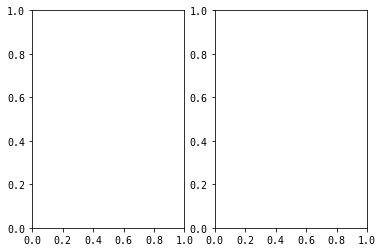

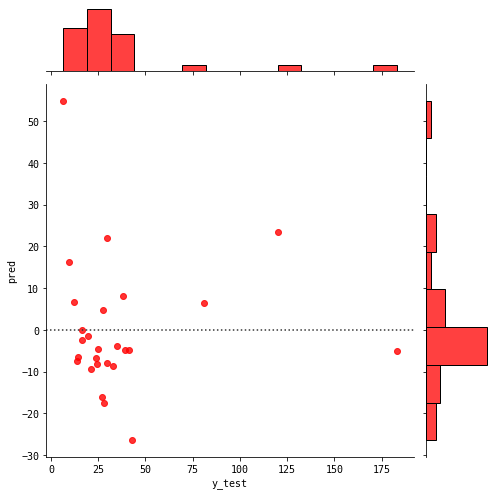

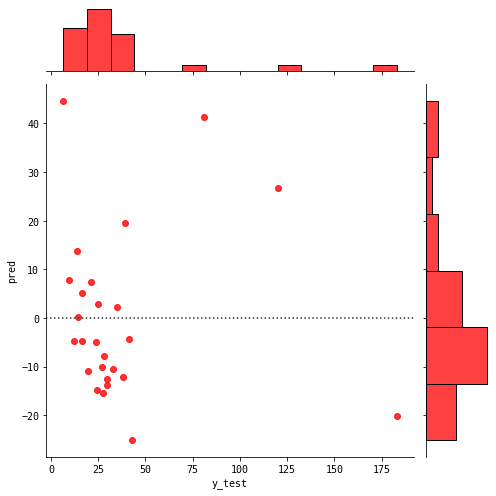

In [ ]:
fig = plt.figure()

for i in range(1, 3):
    axes = fig.add_subplot(1, 2, i)
    if(i == 1):
      sns.jointplot(x=df_results_original['y_test'],
                      y=df_results_original['pred'],
                      ax=axis[0],
                      kind="resid",
                      # truncate=False,
                      #xlim=(0, 60), 
                      #ylim=(0, 12),
                      color="r",
                      height=7)
    else:
      sns.jointplot(x=df_results_reduzido['y_test'],
              y=df_results_reduzido['pred'],
              ax=axis[1],
              kind="resid",
              # truncate=False,
              #xlim=(0, 60), 
              #ylim=(0, 12),
              color="r",
              height=7)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

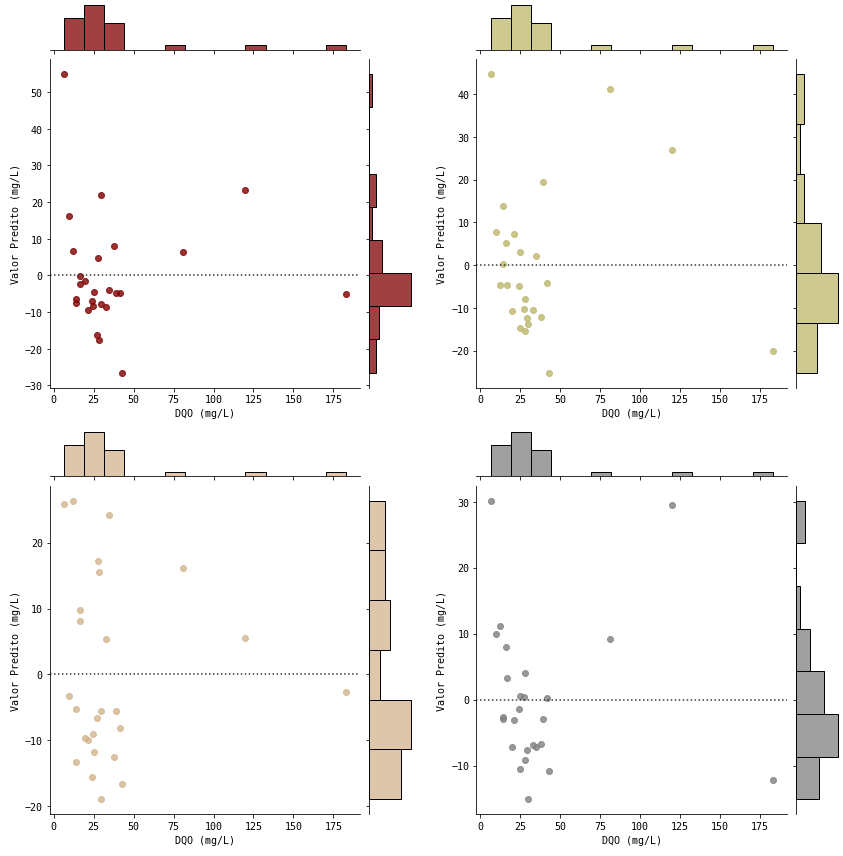

In [ ]:

g0 = sns.jointplot(x=df_results_original['y_test'],
              y=df_results_original['pred'],
              kind="resid",
              # truncate=False,
              #xlim=(0, 60), 
              #ylim=(0, 12),
              color="maroon",

              height=7)
g0.set_axis_labels('DQO (mg/L)', 'Valor Predito (mg/L)') #fontsize= 13 para mudar a o tamanho da fonte

g1= sns.jointplot(x=df_results_reduzido['y_test'],
              y=df_results_reduzido['pred'],
              kind="resid",
              # truncate=False,
              #xlim=(0, 60), 
              #ylim=(0, 12),
              color="darkkhaki",
              height=7)
g1.set_axis_labels('DQO (mg/L)', 'Valor Predito (mg/L)') 

g2 = sns.jointplot(x=df_results_df_CP_95['y_test'],
              y=df_results_df_CP_95['pred'],
              kind="resid",
              # truncate=False,
              #xlim=(0, 60), 
              #ylim=(0, 12),
              color="gray",
              height=7)
g2.set_axis_labels('DQO (mg/L)', 'Valor Predito (mg/L)')

g3 = sns.jointplot(x=df_results_df_CP_reduzido['y_test'],
              y=df_results_df_CP_reduzido['pred'],
              kind="resid",
              # truncate=False,
              #xlim=(0, 60), 
              #ylim=(0, 12),
              color="tan", #tan
              height=7)
g3.set_axis_labels('DQO (mg/L)', 'Valor Predito (mg/L)') 

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, right=.2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[3])
mg3 = SeabornFig2Grid(g3, fig, gs[2])

gs.tight_layout(fig)
#gs.update(right=0.9)


#plt.text(7.8, 12.5, "I am Adding Text To The Plot")
plt.show()

### Boxplot DQO Efluente

[]

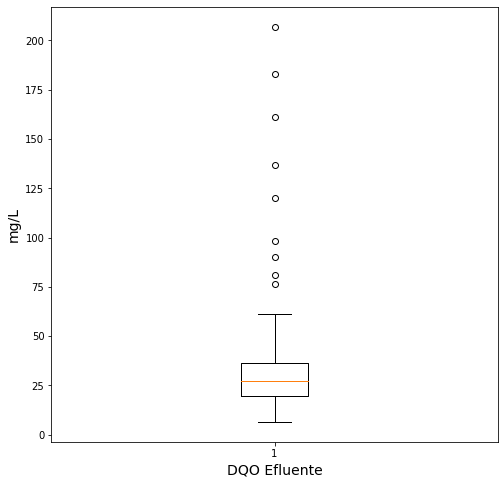

In [ ]:

fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(y)


ax.set_ylabel('mg/L',fontsize=14)
ax.set_xlabel('DQO Efluente',fontsize=14)

plt.plot(
)

In [ ]:
fig.savefig('/content/drive/MyDrive/TCC/MODELS_ANN/teste.png')

In [ ]:
fig.savefig('/content/drive/MyDrive/TCC/MODELS_ANN/resultados.png')